In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.linear_model import RidgeCV, LassoCV, MultiTaskLassoCV
from sklearn.model_selection import cross_val_predict,cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import itertools
import patsy
from IPython.display import HTML
import statsmodels

import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn-paper')
pd.options.display.max_columns = 150
_chars_per_line = 117

# Many thanks to lucacerone and harshil for their contribution to StackOverflow.
html_script = '''<script>code_show=true;function code_toggle(){if (code_show){
 $('div.input').hide();}else{$('div.input').show();}code_show = !code_show}
 $( document ).ready(code_toggle);</script><form action="javascript:code_toggle()">
 <input type="submit" value="Click here to toggle on/off the raw code."></form>'''

def code_toggle(): return HTML(html_script.replace('true','false'))
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


<right><img src="https://thetomatos.com/wp-content/uploads/2016/02/house-clipart-vector-graphics-house-eps-clip-art-vector.jpg" style=" margin: 15px; height: 120px"></right>

## Project 1:  Regression and classification with housing data

### Goals:

There are three goals this project seeks to achive from a technical perspective:

    1. To create a predictive model for the sale price of a property based on its "fixed" and "known" features.
    2. To create a predictive model for sale price of a property as a function of its "alterable" qualities.
    3. To determine the features in the housing data that best predict "abnormal" sales.

Furthermore, in service to the reader (and ourselves) we seek to:

    I.   Present the data, methods and assumptions we are working with in a clear and explicit manner.
    II.  Justify the decicions we make towards the development of our model, and its evaluation.
    
In this project we will be working with the Ames housing data set that consists of records detailing 1460 sales of various properties from 2006 to 2010 in the city of Ames, Iowa.


In [2]:
class GlobalHelper:
    
    global immutable_replace
    def immutable_replace(entry,dictionary = {}):
        if entry in dictionary.keys():
            return dictionary[entry]
        else:
            return entry 
        
    global immutable_replace_with_unknowns
    def immutable_replace_with_unknowns(ser, dictionary, unknown = 'CouldNotBeInferred'):
        pass
        

    global scale_dataframe
    def scale_dataframe(df, method = 'StandardScaler'):
        if method == 'StandardScaler':
            scaler = StandardScaler()
            scaler.fit(df)
            return pd.DataFrame(columns=df.columns,data=scaler.transform(df))
        elif method == 'MinMaxScaler':
            scaler = MinMaxScaler()
            scaler.fit(df)
            return pd.DataFrame(columns=df.columns,data=scaler.transform(df))
        elif method == 'Mixed':
            df_fr = df.copy()
            binary = df.applymap(lambda x: 1 if x ==0 or x == 1 else np.nan).dropna(how='any',axis = 1).columns
            for col in [col for col in df.columns if col not in binary]:
                std = df[col].std()
                xbar = df[col].std()
                df_fr[col] = df[col].apply(lambda x:float(x-xbar)/std) 
            return df_fr
            
        
    
    global plist
    def plist(list_to_print = [], spacing = 14, col_num = 8, title = False):
        '''Prints a list in a pretty way'''
        list_items = [str(item).ljust(spacing) for item in list_to_print]
        if title:print(title+':\n{}'.format('_'*_chars_per_line))
        for i in range(0,len(list_to_print),col_num): 
            [print(list_items[j],end='') for j in range(i,i+col_num) if j < len(list_to_print)]
            print()

    global extended_type
    def extended_type(x):
        if x != x:
            return "<class 'missing'>"
        else:
            return str(type(x))

    global get_m_n
    def get_m_n(N):
        '''find m,n such that an m*n grid can hold N values in a pleasing way'''
        for m in range(int(np.ceil(np.sqrt(N))),N+1):
            for k in range(0,m):
                A = m**2 + m*k
                B = m/2 -1 + m**2 -k*m - m
                if B < N and A >= N: 
                    return (m,m-k)

In [3]:
class DataFrameHelper(pd.DataFrame):
    
    history = []
    
    def set_checkpoint(self):
        self.history.append('set_checkpoint')
        self.checkpoint = self
   
    def reset(self):
        try:
            self.history.append('reset')
            self = self.checkpoint
        except:
            self.history.append('reset failed')
            print('reseting failed')
            

    def explore_types(self, columns = None):      
        if columns == None: columns = self.columns
        
        di = {key:self[key].apply(extended_type).value_counts() for key in columns}
        return pd.DataFrame(columns = columns, data = di)
    
    def pcolumns(self,columns = None, spacing = 14, col_num = 8):
        '''Prints the column names in a pretty way. 
        The default is to print all columns, but a list may be passed.'''
        if columns == None: columns = self.columns
        plist(columns, spacing, col_num)
    
    def puniques(self,columns, spacing=7,col_num=16):
        for col in columns:
            print(col+':\n{}'.format('_'*115))
            plist(self[col].unique(), spacing=spacing,col_num=col_num)
            print()
    
    def plot_value_occurences(self,normed = False, columns = None, 
                              fig_size = (15,15), xmarks = False,ymarks=True,mn = None, verbose = 0):
        if columns == None: columns = self.columns.tolist()
            
        num_of_cols = len(columns)
        if verbose > 0: print('Generating ',num_of_cols,' plots')
        if mn == None:
            m,n = get_m_n(num_of_cols)
        else:
            m,n = mn
        
        plt.clf()
        plt.figure(figsize=fig_size)
        plt.suptitle('Histogram of unique values',fontsize=25)
        
        for i in range(num_of_cols):
            col = columns[i]
            plt.subplot(m,n,i+1)
            plt.title(col)
            self[col].value_counts(dropna = False).plot(kind='bar');
            if xmarks == False: plt.xticks([])
            if ymarks == False: plt.yticks([])
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        return None
    
    def plot_poly_regplot(self,target,deg = 1, columns = None, 
                              fig_size = (15,15), xmarks = True,ymarks = False,mn = None,
                              low = False,ylab = False,xlab = False,alph = 0.5,verbose = 0):
        if columns == None: columns = self.describe().columns.tolist()
            
        num_of_cols = len(columns)
        if verbose > 0 :print('Generating ',num_of_cols,' plots')
        if mn == None:
            m,n = get_m_n(num_of_cols)
        else:
            m,n = mn
        
        plt.clf()
        plt.figure(figsize=fig_size)
        plt.suptitle('Polynomial fit of unique values',fontsize=25)
        
        for i in range(num_of_cols):
            try:
                col = columns[i]
                plt.subplot(m,n,i+1)
                plt.title(col)
                sns.regplot(self[col],self[target], order = deg, lowess= low,scatter_kws = {'alpha':alph})
                if xmarks == False: plt.xticks([])
                if ymarks == False: plt.yticks([])
                if xlab == False: plt.xlabel('')
                if ylab == False: plt.ylabel('')
            except:
                print('Something went wrong while exploring {}'.format(columns[i]))
                pass
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)
        plt.show()
        return None
    
    def plot_types(self, columns = None, split = 4, figsize = (17,2)):
        _ = plt.clf();
        _ = self.explore_types(columns = columns).T.plot(kind='bar',figsize=figsize, stacked=True, legend=None);
        _ = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", borderaxespad=0.);
        _ = plt.suptitle('Occurence of types in attributes',fontsize=25);
        _ = plt.subplots_adjust(top=0.80);
        _ = plt.show();
        return None
        

In [4]:
class ProjectHelper(DataFrameHelper):
    '''This Class is hard coded for this project. Its methods are useful for data cleaning.'''
    
    #definition of essentialy nessesary data cleaning
    def impute_typos(self):
        COPY = self.copy()
        COPY.history.append('impute_typos')
        COPY.loc[948,'BsmtExposure'] = 'No'
        COPY.loc[332,'BsmtFinType2'] = 'Unf'
        COPY.loc[1379,'Electrical'] = 'SBrkr'
        return COPY
    
    def impute_correct_type_to_MSSubClass(self):
        self.history.append('impute_correct_type_to_MSSubClass')
        
        MSSubClass_dict ={
            20:'1-STORY 1946 & NEWER ALL STYLES',
            30:'1-STORY 1945 & OLDER',
            40:'1-STORY W/FINISHED ATTIC ALL AGES',
            45:'1-1/2 STORY - UNFINISHED ALL AGES',
            50:'1-1/2 STORY FINISHED ALL AGES',
            60:'2-STORY 1946 & NEWER',
            70:'2-STORY 1945 & OLDER',
            75:'2-1/2 STORY ALL AGES',
            80:'SPLIT OR MULTI-LEVEL',
            85:'SPLIT FOYER',
            90:'DUPLEX - ALL STYLES AND AGES',
            120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
            150:'1-1/2 STORY PUD - ALL AGES',
            160:'2-STORY PUD - 1946 & NEWER',
            180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
            190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'}
        
        self['MSSubClass'] = self['MSSubClass'].apply(lambda x: immutable_replace(x,MSSubClass_dict))

    def impute_0_to_nan(self):
        '''We impute 0 to nan for every occurence in some columns (because 0 is a suitable value of an area)'''
        self.history.append('impute_0_to_nan')
        
        for col in ['LotFrontage','MasVnrArea']:
            self[col].fillna(value = 0,inplace=True)
    
    def impute_None_to_nan(self):
        '''We impute the string 'None' to nan (because no such feature is present)'''
        
        self.history.append('impute_None_to_nan')
        for col in ['Alley','MasVnrType','BsmtFinType2','GarageType','PoolQC','Fence','MiscFeature']:
            self[col].fillna(value = 'None',inplace=True)
    
    def impute_NotApplicable_to_nan(self):
        '''We impute 'NotApplicable' to nan (because this is an atribute of a feature that is not present)'''
        self.history.append('impute_NotApplicable_to_nan')
        
        for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','FireplaceQu','GarageYrBlt',
                    'GarageFinish','GarageQual','GarageCond']:
            self[col].fillna(value = 'NotApplicable',inplace=True)
        
        
  
    # Perform the above imputation methods one after another.
    def impute(self):
        self.history.append('impute...')
        self.impute_typos()
        self.impute_correct_type()
        self.impute_0_to_nan()
        self.impute_None_to_nan()
        self.impute_NotApplicable_to_nan()
    
    #definition of 'optional' data cleaning
    def cast_quality_to_numbers(self,NA = 0):
        self.history.append('cast_quality_to_numbers')
        quality_to_number_dict = {
           'Ex':5,
           'Gd':4,
           'TA':3,
           'Fa':2,
           'Po':1,
           'NA':NA,
           'NotApplicable': NA}
        
        for col in ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                    'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']:
            self[col] = self[col].apply(lambda x: immutable_replace(x,quality_to_number_dict))
    
    def cast_land_slope_to_numbers(self):
        self.history.append('cast_land_slope_to_numbers')
        LandSlope_dict = {
           'Gtl':0, #Gentle slope
           'Mod':1, #Moderate Slope
           'Sev':2} #Severe Slope
        self['LandSlope'] = self['LandSlope'].apply(lambda x: immutable_replace(x,LandSlope_dict))       
    
    #definition of methods for quality of life improvements.
    def get_years(self,LIST = [2010]):
        if not isinstance(LIST,list): LIST = [LIST]
        mask = [True if x in LIST else False for x in self['YrSold']]
        return self[mask]
    

In [5]:
class ModelingReport:
    def __init__(self,model,X,y,naive_score,cv_score,true_score):
        self.model = model
        self.X = X
        self.y = y 
        self.naive_score = naive_score
        self.cv_score = cv_score
        self.true_score = true_score
        self.stored_settings = None
    
    def to_df(self):
        rec = pd.DataFrame(columns=['report', 'model','naive_score','true_score','cv_score'],
                           data={'report':self,'model':self.model,'naive_score':self.naive_score,
                                 'cv_score':self.cv_score,'true_score':self.true_score},index = ['rec:'])
        
        if self.stored_settings != None:
            settings = pd.DataFrame(self.stored_settings,index=['rec:'])
            rec = pd.concat([rec,settings],axis=1)
        return rec
    
    def remember_config(self,di):
        self.stored_settings = di

In [6]:
def implement_modeling(
    df,
    target = 'SalePrice',
    ignore_colums = None,
    consider_columns = None,
    
    model='lm',
    model_alpha = 1,
    
    get_dummies = True, 
    dummy_columns = None,
    do_drop_first = False,
    

    scale_technique = None):
    
    '''This function performs most actions that would normaly be associated to implementing 
    and assessing a regression model.
    
    it returns an object called model_report that contains 
    the key elements of the implementation and assesment as atributes.
    
    The model_report contains as atributes the model and feature matrix 
    so that further exploration can be done with ease'''
    
    try:
        test = (df['YrSold'] == 2010).values
        train = (df['YrSold'] != 2010).values
    except:
        pass
    
    X = df.drop([target],axis=1)
    y = df[target]
    
    # using specific colums or ignoring others
    if consider_columns != None:
        X = X[consider_columns]
    if ignore_colums != None:
        X = X.drop([col for col in ignore_colums if col in X.columns],axis = 1)
    
    # Select a model and initialize it with the appropiate hyperparameters
    if model == 'lm':
        model = LinearRegression()
    elif model == 'ridge':
        model = Ridge(alpha = model_alpha)
    elif model == 'lasso':
        model = Lasso(alpha = model_alpha)

    # Get dummie variables
    # This will dummify columns if you specify them, or dummify all non numeric columns if you do not
    
    if get_dummies == True or dummy_columns != None:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = pd.get_dummies(data = X,columns = dummy_columns, drop_first=do_drop_first)
        X.columns = [col.replace(' ','_') for col in X.columns]
    else:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = X.drop(dummy_columns,axis=1)

    # Perform scaling
    
    if scale_technique != None:
        X = scaler(X,scale_technique)
        
    ''' # model fitting and evaluation: 
    model.fit(X,y)
    
    naive_score = model.score(X,y)
    cv_score = r2_score(y,cross_val_predict(model,X,y))
    
    model.fit(X[train],y[train])
    true_score = model.score(X[test],y[test])
    
    gs = 
    
    model_report = ModelingReport(model,X,y,naive_score,cv_score,true_score)
    
    model_report.remember_config({'alpha':model_alpha,'scaling':scale_technique,
                                  'get_dummies':get_dummies,'features':X.shape[1]})
    
    return model_report'''

    return (X,y)

In [7]:
def getXy(
    df,
    target = 'SalePrice',
    ignore_colums = None,
    consider_columns = None,
    
    drop_col_if_contains_nan = True,
    
    cast_into_other = [],
    
    get_dummies = True, 
    dummy_columns = None,
    do_drop_first = False,
    drop_specifically = [],
    
    scale_technique = None,
    train_test = False,
    test_set = 1):
    
    '''This function performs most actions that would normaly be associated to preparing 
    a frature and target matrix for procesing'''
    
    X = df.drop([target],axis=1)
    y = df[target]
    
    if train_test == True:
        if  type(test_set) == int: 
            test = [True]*y.count()
            train = [True]*y.count()
        else:
            test = test_set
            train = [not i for i in test_set]
    
    # using specific colums or ignoring others
    if consider_columns != None:
        X = X[consider_columns]
    if ignore_colums != None:
        X = X.drop([col for col in ignore_colums if col in X.columns],axis = 1)

    # drop columns or rows when a a missing value is found.
    if drop_col_if_contains_nan:
        X = X.dropna(how = 'any',axis = 1)
    else:
        X = X.dropna(how = 'any',axis = 0)
        
    # Perform a map from old values to new values on specific columns.
    for col,di in cast_into_other:
        X[col] = X[col].apply(lambda x: immutable_replace(x,di))

    # Get dummie variables: This will dummify columns if you specify them, 
    # or dummify all non numeric columns if you do not specify any.
    
    if get_dummies == True or dummy_columns != None:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = pd.get_dummies(data = X,columns = dummy_columns, drop_first=do_drop_first)
        X.columns = [col.replace(' ','_') for col in X.columns]
    else:
        if dummy_columns == None: dummy_columns = [col for col in X.columns if col not in X.describe().columns]
        X = X.drop(dummy_columns,axis=1)

    X = X.drop(drop_specifically, axis = 1)
    
    # Perform scaling
    if scale_technique != None:
        X = scale_dataframe(X,scale_technique)

    if train_test == True:
        return (X[[not i for i in test_set]],X[test_set],y[[not i for i in test_set]],y[test_set])
    return (X,y)

In [ ]:
print('_'*_chars_per_line)
code_toggle()Regression

<right><img src="https://images.vexels.com/media/users/3/143466/isolated/preview/b47bfb19d11e66c3be00ccb0632047ce-lupa-simples-by-vexels.png" style=" margin: 15px; height: 120px"></right>

### 1. Examining and cleaning the data 

Of the 1460 records, 1450 pertain to the sale of residential properties. We focus soley on these, since ultimately we have neither the interest, nor a suficient amount of data to build a reliable model for non-residential properties.

<a href="https://git.generalassemb.ly/raw/DSI-LDN-3/lessons-repo/master/projects/project-02/data_description.txt?token=AAAY4q6W44WqbDLYg_WJiPApoQi-l2qrks5ZeROlwA%3D%3D" target="_blank">Feature Descriptions</a>

In [8]:
data_set = pd.read_csv('../../../lessons-repo/projects/project-02/housing.csv')
data_set.drop(['Id'],axis=1,inplace=True)

residential = data_set['MSZoning'].isin(['FV','RH','RL','RM'])

df = DataFrameHelper(data_set[residential])
df.head()

test_set = df['YrSold'] == 2010


The 80 features associated with a sale are:


In [9]:
df.pcolumns()

MSSubClass    MSZoning      LotFrontage   LotArea       Street        Alley         LotShape      LandContour   
Utilities     LotConfig     LandSlope     Neighborhood  Condition1    Condition2    BldgType      HouseStyle    
OverallQual   OverallCond   YearBuilt     YearRemodAdd  RoofStyle     RoofMatl      Exterior1st   Exterior2nd   
MasVnrType    MasVnrArea    ExterQual     ExterCond     Foundation    BsmtQual      BsmtCond      BsmtExposure  
BsmtFinType1  BsmtFinSF1    BsmtFinType2  BsmtFinSF2    BsmtUnfSF     TotalBsmtSF   Heating       HeatingQC     
CentralAir    Electrical    1stFlrSF      2ndFlrSF      LowQualFinSF  GrLivArea     BsmtFullBath  BsmtHalfBath  
FullBath      HalfBath      BedroomAbvGr  KitchenAbvGr  KitchenQual   TotRmsAbvGrd  Functional    Fireplaces    
FireplaceQu   GarageType    GarageYrBlt   GarageFinish  GarageCars    GarageArea    GarageQual    GarageCond    
PavedDrive    WoodDeckSF    OpenPorchSF   EnclosedPorch 3SsnPorch     ScreenPorch   PoolArea    

Soon we will classify these properties as either:

    1. Fixed         (it would not be feasible to alter these attributes)
    2. Alterable     (it would be possible to alter these attributes)
    3. Descriptive   (it describes another feature)
    4. Incidental    (it is an attribute of the specific sale)
    5. Derivative    (it can be deduced to a high degree of accuracy from other attributes)
    
But first we inspect our data for missing values and deal with them on a case-by-case basis.

#### 1.1 Verifying the quality of the data

We seek to identify and replace our missing values.

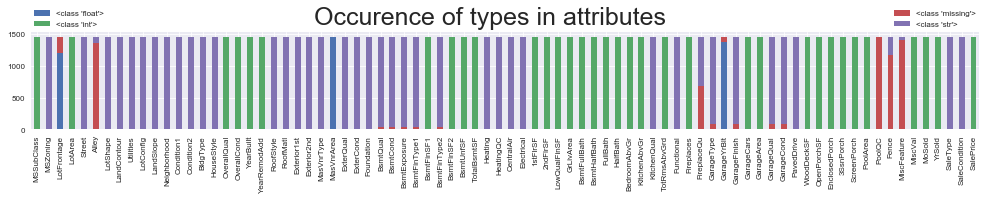

In [10]:
df.plot_types()

In [11]:
examine_closer = [col for col in df.columns if df[col].isnull().any()]
examine_closer_str = [col for col in examine_closer if df[col].apply(lambda x: isinstance(x,str)).any()]
examine_closer_num = [col for col in examine_closer if col not in examine_closer_str]
plist(examine_closer, title = 'Attributes with Missing Values')

Attributes with Missing Values:
_____________________________________________________________________________________________________________________
LotFrontage   Alley         MasVnrType    MasVnrArea    BsmtQual      BsmtCond      BsmtExposure  BsmtFinType1  
BsmtFinType2  Electrical    FireplaceQu   GarageType    GarageYrBlt   GarageFinish  GarageQual    GarageCond    
PoolQC        Fence         MiscFeature   


We start by taking a look at attributes where the entries that are present are strings.

We look at their unique values and the frequency of their incidence.

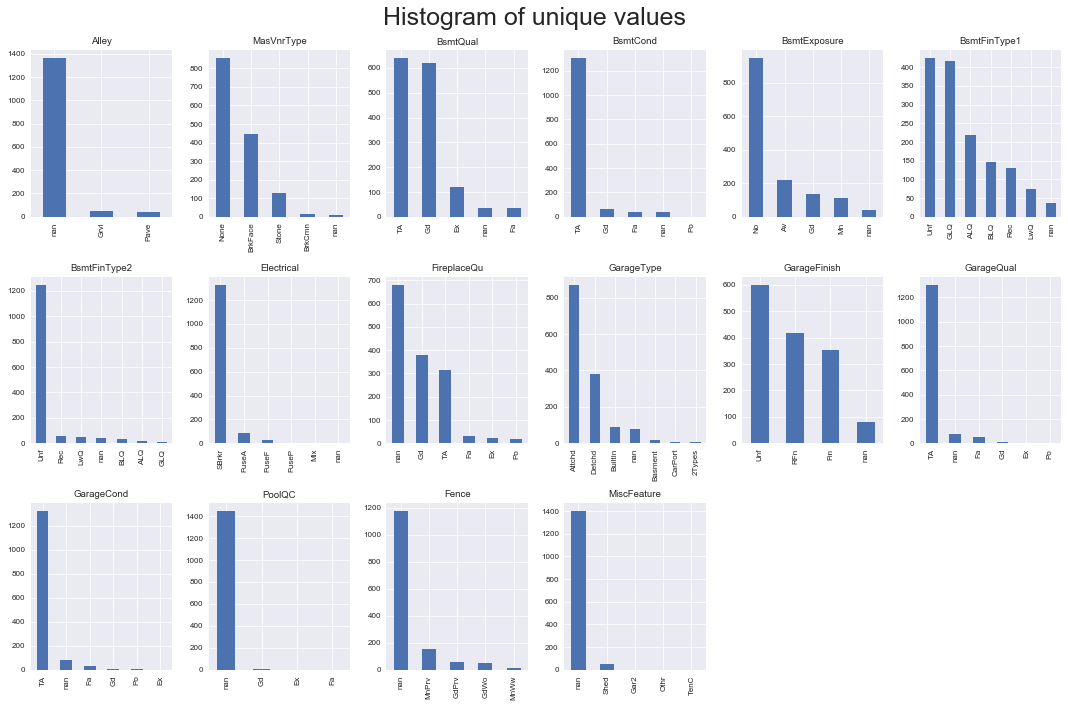

In [12]:
df.plot_value_occurences(columns = examine_closer_str,xmarks = True,fig_size=(15,10),mn=(3,6))

We notice many of these features are descriptors of other features, or of attributes of the house. In this context the'NA' value in the housing.csv file that was used to indicate that a feature is not present. We replace these missing values with the string 'DescribesMissing'. We do this for 2 reasons:

    1. For many of these features we will end up using dummy variables, which do not 
       handle np.nan well, but can easily incorporate one more category. 
    
    2. We hope we can later inspect these values further perhaps as part of some feature egeneering.
       A descriptive entry will be helpful in conceptualising futher analysis.
    
The features for which we replace nan with 'DescriptorMissing' are: 

    BsmtQual      BsmtCond      BsmtExposure  BsmtFinType1  BsmtFinType2      FireplaceQu   
    GarageFinish  GarageQual    GarageCond    PoolQC        

However, for:

    Alley         Fence         MiscFeature   GarageType

we replace missing values with the string 'None' following the convention used in the describing the type of facade (MasVnrType). In describing the type of covering of the walls, they allow the absence of any covering to be a valid covering kind in and of itself.


Regarding MasVnrType itself:

we could replace nan with 'None', but this would amount to assuming data input errors. Rather than moving forward with this assumption, we explore another possibility:

In [13]:
df[df['MasVnrType'].isnull()][['MasVnrType','SaleCondition','YearRemodAdd','YrSold']]

,MasVnrType,SaleCondition,YearRemodAdd,YrSold
234,NaN,Normal,2002,2010
529,NaN,Alloca,1975,2007
650,NaN,Normal,2007,2008
936,NaN,Normal,2003,2009
973,NaN,Partial,2008,2008
977,NaN,Partial,2007,2007
1243,NaN,Partial,2006,2006
1278,NaN,Normal,2002,2008


As we can see, 3 of the 8 properties with nan MasVnrType were only partially built. It would be wrong to assume any one kind of veneer will be used (or intentionally left with no veneer). Our plan is then to replace nan with "CouldNotBeInferred" in the understanding that at the time of creating dummy variables.

We could apply the same reasoning to Electrical, where the missing value corresponds a property we believe is undergoing remodelling. 

In [14]:
df[df['Electrical'].isnull()][['Electrical','CentralAir','SaleCondition','YearBuilt','YearRemodAdd','YrSold']]

,Electrical,CentralAir,SaleCondition,YearBuilt,YearRemodAdd,YrSold
1379,NaN,Y,Normal,2006,2007,2008


However we choose to side with a 'nearest-neighbors-style' heuristic, and impute a value of "SBrkr" to this nan value.

As a justification, note that property 1379 was built in 2006, and 100% of properties built between 1965 and 2010 have used "SBrkr" as their Electrical system.

In [15]:
df[np.abs(df['YearBuilt'] - 2007) < 42]['Electrical'].value_counts(dropna= False)

SBrkr    869
NaN        1
Name: Electrical, dtype: int64

In [16]:
# We performe the replacements discussed above
descriptors = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PoolQC']

df.fillna({col:'DescribesMissing' for col in descriptors},inplace = True)

df.fillna({'Alley':'None','Fence':'None','MiscFeature':'None','GarageType':'None'},inplace = True)

df.fillna({'MasVnrType':'CouldNotBeInferred'},inplace = True)

df.fillna({'Electrical':'SBrkr'},inplace = True)

_ = None

It remains for us to deal with the missing entries in columns that are mostly numeric.

These are:

In [17]:
plist([c for c in examine_closer if c not in examine_closer_str])

LotFrontage   MasVnrArea    GarageYrBlt   


We interpret a missing value in LotFrontage and MasVnrArea to represent a length and area of 0 respectively. However, no such easy way of dealing with GarageYrBlt is available. One option would be to drop the 37 records for which there is a missing value in GarageYrBlt, but we do not wish to omit the properties without a garage from our model since we believe the presence or absence of a garage may be very significant. 

Moreover we have plenty of information regarding the garage of the properties that have them. And a garage area of 0 is a surefire way to deduce the absence of a garage, and hence the absence of a GarageYrBlt value.

We will soon consider dropping the feature from our analysis, but for the time being, we replace nan with "DescribesMissing".

In [18]:
df.fillna({'LotFrontage':0,'MasVnrArea':0},inplace=True)

df.fillna({'GarageYrBlt':'DescribesMissing'},inplace = True)

df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: str(x))

_ = None

Lastly, we note that the MSSubClass attribute is encoded as integers. However, it is clearly meant to be a category as indicated in the <a href="https://git.generalassemb.ly/raw/DSI-LDN-3/lessons-repo/master/projects/project-02/data_description.txt?token=AAAY4q6W44WqbDLYg_WJiPApoQi-l2qrks5ZeROlwA%3D%3D" target="_blank">data description</a> file associated to the Ames housing data set. The encoding is:

             20:'1-STORY 1946 & NEWER ALL STYLES'
             30:'1-STORY 1945 & OLDER'
             40:'1-STORY W/FINISHED ATTIC ALL AGES'
             45:'1-1/2 STORY - UNFINISHED ALL AGES'
             50:'1-1/2 STORY FINISHED ALL AGES'
             60:'2-STORY 1946 & NEWER'
             70:'2-STORY 1945 & OLDER'
             75:'2-1/2 STORY ALL AGES'
             80:'SPLIT OR MULTI-LEVEL'
             85:'SPLIT FOYER'
             90:'DUPLEX - ALL STYLES AND AGES'
            120:'1-STORY PUD (Planned Unit Development) - 1946 & NEWER'
            150:'1-1/2 STORY PUD - ALL AGES'
            160:'2-STORY PUD - 1946 & NEWER'
            180:'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'
            190:'2 FAMILY CONVERSION - ALL STYLES AND AGES'
            
We replace the integer codes with a strings that describe each category (we use our own lables to be less verbose, but this does not affect the information in available in any way). This gives us the a DataFrame with no missing values moving forward.



In [19]:
MSSubClass_dict ={
            20:'1S_>1946',
            30:'1S_<1945',
            40:'1S_ATTIC',
            45:'1.5S_UNF',
            50:'1.5S_FIN',
            60:'2S_>1946',
            70:'2S_<1945',
            75:'2.5S',
            80:'SPL_OR_ML',
            85:'SPL_FOYER',
            90:'DUPLEX',
            120:'1S_PUD_>1946',
            150:'1.5S_PUD',
            160:'2S PUD_>1946',
            180:'PUD_ML',
            190:'2_FC'}

df['MSSubClass'] = df['MSSubClass'].apply(lambda x: immutable_replace(x,MSSubClass_dict))

We are aware that many of the distinctions between these categories (such as references to being pre or post 1945) could be inferred from the YearBuilt, BldgType and HouseStyle attributes. 

We will shortly explore this issue, but first we perform some exploratory data analysis now that our data is free of missing values.

In [ ]:
print('_'*_chars_per_line)
code_toggle()

<right><img src="https://thetomatos.com/wp-content/uploads/2016/09/black-microscope-clipart.png" style=" margin: 15px; height: 120px"></right>

### Section 2: Exploratory data analysis

Let us take a quick look at our current features. In particular we are interested in the the individual power of attributes in predicting our sale price, and of the colinearity of the columns of our feature matrix.

We will somewhat brute force the problem of finding colinearity and predictive power. But before we do that, it is worth taking a look at the pairwise correlation between our numeric attributes. To this end we use a set of heatmaps.

We will use the made-up measure of "total correlation" to zoom in and out of our heatmap. The total correlation of a feature is the sum of the absolute values in its row in the correlation matrix.

    total_correlation(feature) = df.corr()[feature].apply(np.abs).sum()

In [20]:
def plot_heatmatp(df, threshold = None, c_threshold = 1, mx_threshold = 100,weak = 1, target = None):
    if threshold != None:
        corr_above_thresh = df.corr().applymap(lambda x:1 if ((np.abs(x) > threshold) and (np.abs(x) < mx_threshold)) else 0)
    else:
        corr_above_thresh = df.corr()

    cumthresh_mask = [col for col in corr_above_thresh.columns if corr_above_thresh[col].apply(np.abs).sum()*weak 
                      > c_threshold*weak]
    if target != None:
        if target not in cumthresh_mask: cumthresh_mask.append(target)
    return sns.heatmap(corr_above_thresh.loc[cumthresh_mask,cumthresh_mask], linewidths = 0.01)

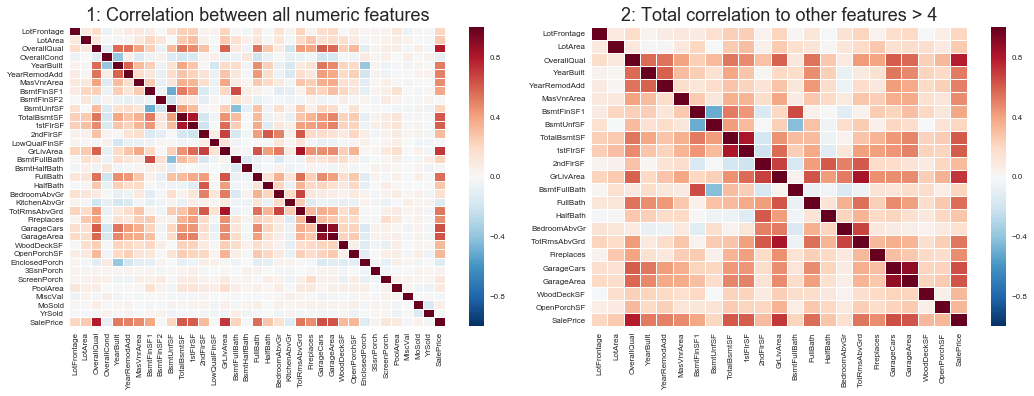

In [21]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,c_threshold = 0)
plt.title('1: Correlation between all numeric features', fontsize = 18)

plt.subplot(2,2,2)
plt.title('2: Total correlation to other features > 4', fontsize = 18)
plot_heatmatp(df,c_threshold = 4)
plt.tight_layout()

plt.show()

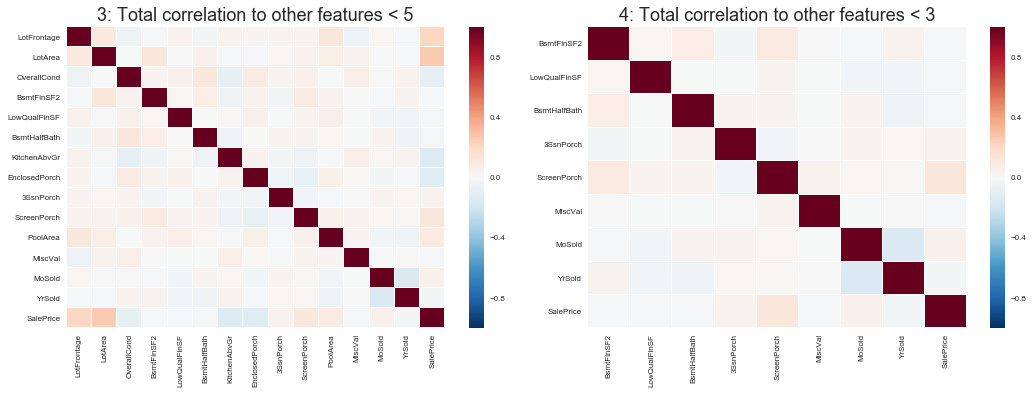

In [22]:
plt.clf()
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,c_threshold = 5,weak = -1, target='SalePrice')
plt.title('3: Total correlation to other features < 5', fontsize = 18)

plt.subplot(2,2,2)
plt.title('4: Total correlation to other features < 3', fontsize = 18)
plot_heatmatp(df,c_threshold = 3, weak = -1,target='SalePrice')
plt.tight_layout()

plt.show()

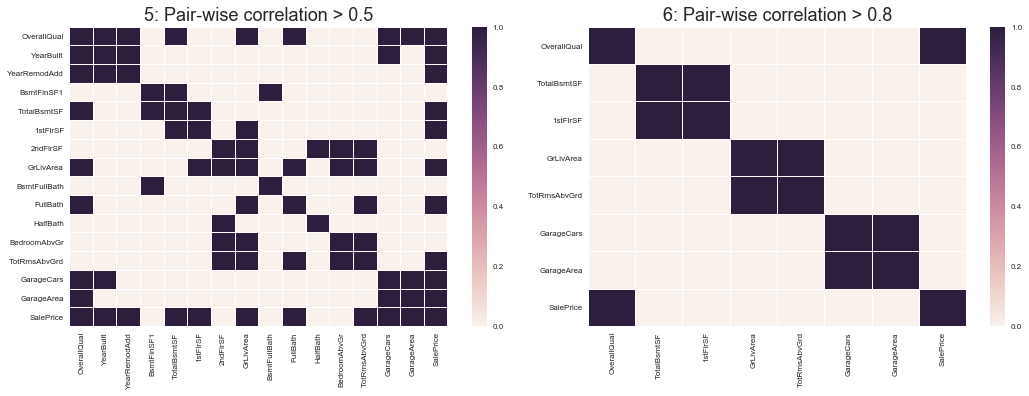

In [23]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(df,threshold=0.5)
plt.title('5: Pair-wise correlation > 0.5', fontsize = 18)

plt.subplot(2,2,2)
plt.title('6: Pair-wise correlation > 0.8', fontsize = 18)
plot_heatmatp(df,threshold=0.75)
plt.tight_layout()

plt.show()

We draw two key conclusions from these heatmaps:

   1. We certainly have strongly correlated features such as 
    
            GarageCars with GarageArea
            GrLivArea  with TotRmsAbvGrd
            OveralQual with SalePrice
            
   2. Some features are indeed weakly pairwise correlated with all other features. 
      We can see this in figures 3 and 4, and this provides further justification for 
      the category of 'Incidental Attribute'.
       
The slightly negative correlation between the month of sale and the year of sale drew our attention to the slight negative skew of the MoSold distribution (which uses a numeric code of 1-12). We note the following:

   - We certainly have features in our data whose impact on the price 
     could not possibly be reflected in a linear or even quadratic model. 
       
   - Real estate firms should expect their services to be needed most in June, 
     and least in September. 

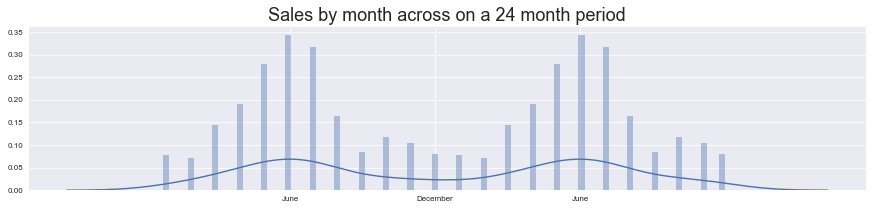

In [24]:
plt.figure(figsize=(15,3))
a_year = df['MoSold'].values
dates = np.concatenate([a_year,a_year+12])

bins = np.linspace(0,24,96)
sns.distplot(dates,bins=bins,norm_hist=True)
plt.xticks([6,12,18],['June','December','June'])
plt.title('Sales by month across on a 24 month period', fontsize = 18)

plt.show()

In [82]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


<right><img src="https://image.freepik.com/free-icon/selected-object_318-31352.jpg" style=" margin: 15px; height: 120px"></right>

### 3. Feature selection and classification

_This is NOT the section where we select our best model; here we use linear regression merely as a tool for feature selection._

Before we begin developing a model for sale price, we take a moment to explore the 'redundancy' in our data. As we shall see, several attributes of a sale are merely linear combinations of other attributes. We can identify these situations for numeric features by setting $x_i$ as the target of a plain linear regression using features $x_1,...x_{i-1},-\square-,x_{i+1},...,x_{n}$ to predict the values of $x_i$. If $x_i$ is in the span the other features we should observe a mean square error of 0, and hence an $\text{R}^2$ value of 1.

In [25]:
# We separate our features into those that are numeric and those that are categorical.
numeric = df.describe().columns.tolist()
categoric = [col for col in df.columns if col not in numeric]

In [26]:
def naive_lm_predict(df,attributes,ignore = None ,verbose = 0, test_set = 1,sp = 24,cn = 4,rnd = 4):
    coef_storage = {}
    results = []
    atrmxlen = max(len(col) for col in attributes)
    if verbose > 1: print('Predicting:\n{}'.format('_'*_chars_per_line))
    
    
    M,ft = getXy(df,target=attributes[0], ignore_colums=ignore)
    M[attributes[0]] = ft
    
    for col in attributes:
        X = M.drop(col, axis= 1)
        y = M[col]
            
        if verbose > 2: 
            print((str(col).ljust(14)+ ' on {} features.'.format(X.shape[1])))
        elif verbose > 1:
            print(str(col), end='|')

        # create masks for a train test split when a test boolean list is passed, 
        # or initialize the trivial mask.
        if  type(test_set) == int: 
            test = [True]*y.count()
            train = [True]*y.count()
        else:
            test = test_set
            train = [not i for i in test_set]
            
        lm = LinearRegression()
        lm.fit(X[train],y[train])
        score = lm.score(X[test],y[test]) 
        coef_storage[col] = pd.DataFrame({'atr':X.columns, 'coef':lm.coef_})
        
        results.append(col.ljust(atrmxlen+1)+':'+str(round(score,rnd)))
        
        if verbose == -1: 
            print('Predicted {} on {} features, scored {}'.format(col,X.shape[1], round(score,rnd)))

    if verbose > 0: plist(results,col_num=cn,spacing=sp,title='\n\nResults')
    return (results, coef_storage)

In [27]:
_ = naive_lm_predict(df, numeric, verbose=1)



Results:
_____________________________________________________________________________________________________________________
LotFrontage   :0.5066   LotArea       :0.7495   OverallQual   :0.8532   OverallCond   :0.6922   
YearBuilt     :0.9552   YearRemodAdd  :0.7741   MasVnrArea    :0.7124   BsmtFinSF1    :1.0      
BsmtFinSF2    :1.0      BsmtUnfSF     :1.0      TotalBsmtSF   :1.0      1stFlrSF      :1.0      
2ndFlrSF      :1.0      LowQualFinSF  :1.0      GrLivArea     :1.0      BsmtFullBath  :0.7041   
BsmtHalfBath  :0.3905   FullBath      :0.7929   HalfBath      :0.7168   BedroomAbvGr  :0.7697   
KitchenAbvGr  :0.8373   TotRmsAbvGrd  :0.8719   Fireplaces    :0.8897   GarageCars    :0.8926   
GarageArea    :0.8885   WoodDeckSF    :0.4126   OpenPorchSF   :0.4706   EnclosedPorch :0.4818   
3SsnPorch     :0.2449   ScreenPorch   :0.357    PoolArea      :0.9963   MiscVal       :0.9685   
MoSold        :0.2733   YrSold        :0.3514   SalePrice     :0.939    


We can observe many interesting things to examine further. And incidentally we can verify that for each of the 1450 properties:

$$\text{TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF}$$

$$\text{GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF}$$

Moving forwards we **drop** the LowQualFinSF and BsmtUnfSF attributes since we know we can deduce them from the remaining features.

In [28]:
df_wd1= df.drop(['LowQualFinSF','BsmtUnfSF'], axis=1)

numeric_wd1 = [col for col in numeric if col not in ['LowQualFinSF','BsmtUnfSF']]
categoric_wd1 = categoric

At this time we are ready to tackle the issue of the GarageYrBlt attribute. For the 37 properties we encountered without a garage, no reasonable way came to mind to codify a value for the garage build year.

We do observe a slight improvement in the naive R2 value by including the column in its categorical form.

In [29]:
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore= None, verbose=-1)
_ = naive_lm_predict(df_wd1, ['SalePrice'],ignore=['GarageYrBlt'],verbose=-1)

Predicted SalePrice on 410 features, scored 0.939
Predicted SalePrice on 313 features, scored 0.9335


However, turning the year in which the garage was built into a categorical variable is a terrible idea for a myriad of reasons. The top 3 that come to mind are:

    1. Due to the many unique values present in the attribute, the number of records corresponding to each 
       would-be category will be too small for us to have any faith in the learned parameters. (We could 
       mitigate this by creating intervals of years, but this does not resolve the issue fully)
       
    2. Our model would be terrible at dealing with new houses or new garages of any kind since all houses built 
       after our model has been fitted will - inevitably - fall into none of the categories present in the 
       training data.
       
    3. Having only 1450 records in our dataset as a whole, properties in total, increasing the 
       dimensionality of our model is not something we should be take lightly.
       
We have certainly made up our minds to drop the attribute, but we may take this chance to explore the concept of Bias-Variance trade-off.

As we can see in the output above, disregarding the GarageYrBlt category would reduce our number of features in a very significant manner. 

Not only will this most likely reduce our model variance, but we suspect that the inclusion of GarageYrBlt does not lead to a significantly lower bias either. We have made up our minds to **drop** GarageYrBlt, but it is quick enough to confirm our intuition.

In [30]:
lm = LinearRegression()
XwithGR,y = getXy(df_wd1, ignore_colums=None)
XnoGr,y = getXy(df_wd1, ignore_colums=['GarageYrBlt'])

Ascore = r2_score(y,cross_val_predict(lm,XwithGR,y, cv = 5))
Bscore = r2_score(y,cross_val_predict(lm,XnoGr,y, cv = 5))

print('Cross-validated score when including GarageYrBlt:',Ascore)
print('Cross-validated score when excluding GarageYrBlt:',Bscore)

Cross-validated score when including GarageYrBlt: 0.77055030581
Cross-validated score when excluding GarageYrBlt: 0.788923017693


In [31]:
##cheat
lasso = Lasso(alpha = 120)
Xt,Xtt,yt,ytt = getXy(df,train_test=True, test_set=test_set)
lasso.fit(Xt,yt).score(Xtt,ytt)

0.91307009733844591

In [32]:
# we drop GarageYrBlt
df_wd2= df_wd1.drop(['GarageYrBlt'], axis=1)

numeric_wd2 = numeric_wd1
categoric_wd2 = [col for col in categoric_wd1 if col not in ['GarageYrBlt']]

Next we turn our attention to the categorical variables in our data.

The inclusion of categorical variables should be done carefully. Not only do they significantly increase the dimensionality of our model, they also introduce several dificulties when new data includes new categories that were not present in the training data.

For these reasons we will seek to reduce the number of categorical variables, or at the very least the number categories within the ones we do not remove.

One clear group of attributes are the ones that collectively describe the kind of house.

In [33]:
house_kind_information = df_wd2[['HouseStyle', 'BldgType', 'MSSubClass']] #1450 records
house_kind_information

def get_uniques(df,spacing=20,col_num=4):
    for col in df.columns:
        print(col+':\n{}'.format('_'*115))
        plist(df[col].unique(), spacing=spacing,col_num=col_num)
        print()
    
_ = get_uniques(df_wd2[['HouseStyle', 'BldgType', 'MSSubClass']])
    


HouseStyle:
___________________________________________________________________________________________________________________
2Story              1Story              1.5Fin              1.5Unf              
SFoyer              SLvl                2.5Unf              2.5Fin              

BldgType:
___________________________________________________________________________________________________________________
1Fam                2fmCon              Duplex              TwnhsE              
Twnhs               

MSSubClass:
___________________________________________________________________________________________________________________
2S_>1946            1S_>1946            2S_<1945            1.5S_FIN            
2_FC                1.5S_UNF            DUPLEX              1S_PUD_>1946        
1S_<1945            SPL_FOYER           SPL_OR_ML           2S PUD_>1946        
2.5S                PUD_ML              1S_ATTIC            



Evidently there are not 8x5x15 = 600 different types of houses, and there is hardly any reason to turn these 3 categorical attributes into 8+5+15 = 28 dummy variables.

One immediate improvement we can do is to drop any year reference from the MSSubClass since this information is already available in the YearBuilt attribute.

In [34]:
# v Due to a typo earlyer this was never applied. 
# v We are happy with our results as they are, oddly enough executing this causes lasso to keep 
# v one more feature without it improving the model at all.
MSSubClass_dict_simplified = {
    '1S >1946': '1S',
    '1S <1945': '1S',
    '2S >1946': '2S',
    '2S <1945': '2S',
    '1S PUD >1946': '1S PUD',
    '2S PUD >1946': '1S PUD'}

df_wd2 = df_wd2.applymap(lambda x: immutable_replace(x, MSSubClass_dict_simplified))
# ^
# ^

house_kind_information = df_wd2[['HouseStyle', 'BldgType', 'MSSubClass']] #1450 records

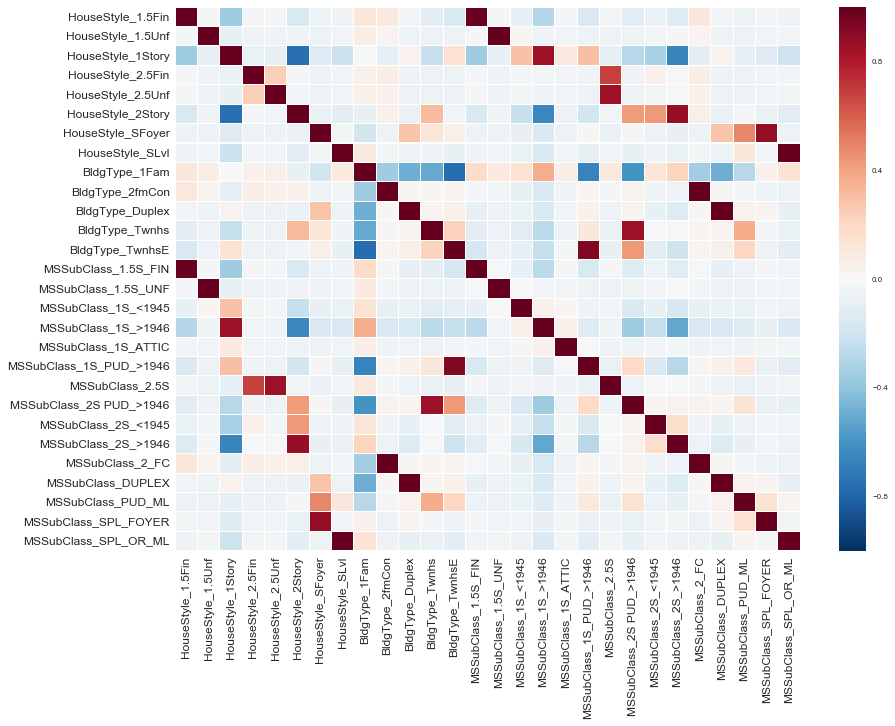

In [35]:
dummified_house_kinds = pd.get_dummies(house_kind_information,drop_first=False)
dummified_house_kinds_c = dummified_house_kinds.corr()
plt.figure(figsize=(14,10))
plot_heatmatp(dummified_house_kinds_c)
plt.xticks(size = 12)
plt.yticks(size= 12)
plt.show()

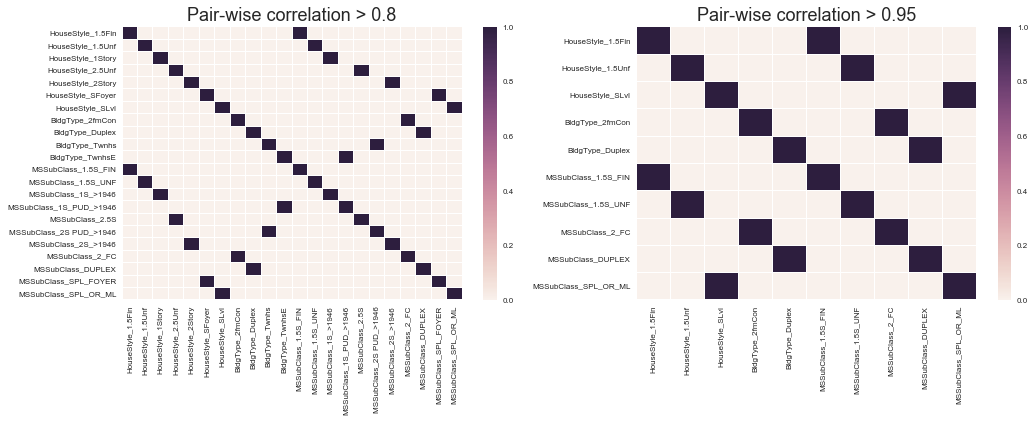

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plot_heatmatp(dummified_house_kinds_c,threshold=0.8,c_threshold=1)
plt.title('Pair-wise correlation > 0.8', fontsize = 18)

plt.subplot(2,2,2)
plt.title('Pair-wise correlation > 0.95', fontsize = 18)
plot_heatmatp(dummified_house_kinds_c,threshold=0.95,c_threshold=1)
plt.tight_layout()

plt.show()

However, this pair-wise analysis fails to identify the situation in the value of one column may be deduced by taking into account several other columns at once. We use LinearRegression again to identify this situation.

In [37]:
cols1 = [col.replace(' ','_') for col in dummified_house_kinds.columns]
_ = naive_lm_predict(dummified_house_kinds,cols1,verbose=1, sp = 27)



Results:
_____________________________________________________________________________________________________________________
HouseStyle_1.5Fin       :1.0HouseStyle_1.5Unf       :1.0HouseStyle_1Story       :1.0HouseStyle_2.5Fin       :1.0
HouseStyle_2.5Unf       :1.0HouseStyle_2Story       :1.0HouseStyle_SFoyer       :1.0HouseStyle_SLvl         :1.0
BldgType_1Fam           :1.0BldgType_2fmCon         :1.0BldgType_Duplex         :1.0BldgType_Twnhs          :1.0
BldgType_TwnhsE         :1.0MSSubClass_1.5S_FIN     :1.0MSSubClass_1.5S_UNF     :1.0MSSubClass_1S_<1945     :1.0
MSSubClass_1S_>1946     :1.0MSSubClass_1S_ATTIC     :1.0MSSubClass_1S_PUD_>1946 :1.0MSSubClass_2.5S         :1.0
MSSubClass_2S_PUD_>1946 :1.0MSSubClass_2S_<1945     :1.0MSSubClass_2S_>1946     :1.0MSSubClass_2_FC         :1.0
MSSubClass_DUPLEX       :1.0MSSubClass_PUD_ML       :1.0MSSubClass_SPL_FOYER    :1.0MSSubClass_SPL_OR_ML    :1.0


As this results suggest, it is imperative that we discard redundant columns in the dummified_house_kinds feature matrix.

One quick way to check if a column is superfluous is to look at the number of unique rows before and after dropping it. If the number is the same, we then know that it was superfluos. 


In [38]:
dummified_house_kinds.drop_duplicates().shape

(42, 28)

In [39]:
redundant = []
# We found that the maximum number of columns we can drop from the MSSubClass group
# without losing information is 8. 
for categs in itertools.combinations(house_kind_information['MSSubClass'].unique(),8):
    before = dummified_house_kinds.drop_duplicates().shape[0]
    after = dummified_house_kinds.drop(['MSSubClass_' + categ for categ in categs], 
                                       axis = 1).drop_duplicates().shape[0]
    if before == after: 
        redundant.append(categs)
        
plist([],col_num=6,title='Columns we can drop without losing information')

plist(sorted(redundant[0]))
print('\n**or**\n')
plist(sorted(redundant[1]))


Columns we can drop without losing information:
_____________________________________________________________________________________________________________________
1.5S_UNF      1S_ATTIC      2S PUD_>1946  2S_>1946      2_FC          DUPLEX        PUD_ML        SPL_FOYER     

**or**

1.5S_UNF      1S_PUD_>1946  2S PUD_>1946  2S_<1945      2_FC          DUPLEX        SPL_FOYER     SPL_OR_ML     


We have two sets of candidate columns to drop from our dummy feature matrix, and it boils down to which entry in the MSSubClass we wish to infer from the remaining columns:

    1.5Fin or 2.5S

In [40]:
to_drop = sorted(['MSSubClass_' + categ for categ in redundant[0]])
plist(sorted(to_drop), col_num= 4, spacing=28, 
      title='In the end we choose to drop the following columns from the feature matrix')


In the end we choose to drop the following columns from the feature matrix:
_____________________________________________________________________________________________________________________
MSSubClass_1.5S_UNF         MSSubClass_1S_ATTIC         MSSubClass_2S PUD_>1946     MSSubClass_2S_>1946         
MSSubClass_2_FC             MSSubClass_DUPLEX           MSSubClass_PUD_ML           MSSubClass_SPL_FOYER        


In [41]:
dummified_house_kinds_wd1 = dummified_house_kinds.drop(to_drop, axis = 1)

This gives us a minimal group of dummy columns generated out of the entries in the MSSubClass attribute.

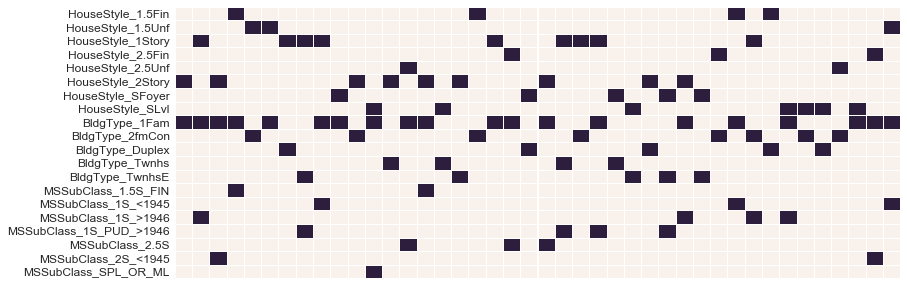

In [42]:
plt.figure(figsize=(13,5))
sns.heatmap(dummified_house_kinds_wd1.drop_duplicates().T,xticklabels=False,linewidths=0.01,cbar = False)
plt.yticks(size = 12)
plt.show()

With some sorting of the columns of the plot above, we can see that the remaining MSSubClass dummy columns need to be kept to distinguish between house types when the information in BldgType and HouseStyle the same.

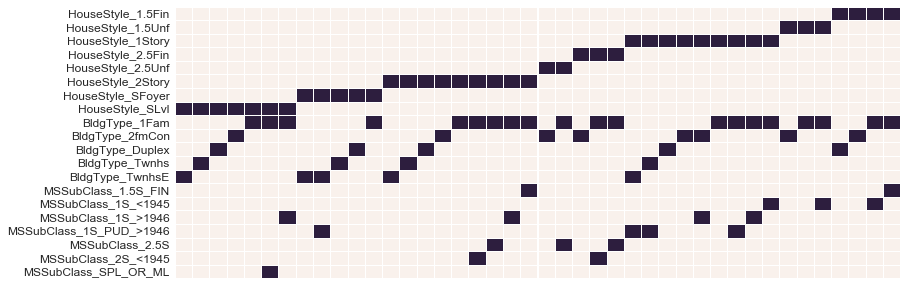

In [43]:
sorted_dummies = dummified_house_kinds_wd1.drop_duplicates().sort_values(by= dummified_house_kinds_wd1.columns.tolist())

plt.figure(figsize=(13,5))
sns.heatmap(sorted_dummies.T,xticklabels=False,linewidths=0.01,cbar = False)
plt.yticks(size = 12)
plt.show()

However, note that this is not a minimal spanning set. A similar reasoning would have to be applied to eliminate redundant columns generated from the categories in HouseStyle and BldgType.

In [44]:
cols2 = [col.replace(' ','_') for col in dummified_house_kinds_wd1.columns]
_ = naive_lm_predict(dummified_house_kinds_wd1, cols2, verbose=1,sp = 27)



Results:
_____________________________________________________________________________________________________________________
HouseStyle_1.5Fin       :1.0HouseStyle_1.5Unf       :1.0HouseStyle_1Story       :1.0HouseStyle_2.5Fin       :1.0
HouseStyle_2.5Unf       :1.0HouseStyle_2Story       :1.0HouseStyle_SFoyer       :1.0HouseStyle_SLvl         :1.0
BldgType_1Fam           :1.0BldgType_2fmCon         :1.0BldgType_Duplex         :1.0BldgType_Twnhs          :1.0
BldgType_TwnhsE         :1.0MSSubClass_1.5S_FIN     :0.9086MSSubClass_1S_<1945     :0.7287MSSubClass_1S_>1946     :0.9359
MSSubClass_1S_PUD_>1946 :0.832MSSubClass_2.5S         :0.7949MSSubClass_2S_<1945     :0.1246MSSubClass_SPL_OR_ML    :0.894


From looking at the image above, we choose to drop:
    
    'BldgType_Duplex' and 'HouseStyle_1.5Unf'

In [45]:
df_fe1 = pd.concat([df_wd2.T, dummified_house_kinds_wd1.T]).T.drop(['HouseStyle', 'BldgType', 'MSSubClass'], axis=1)
df_fe1 = df_fe1.drop(['BldgType_Duplex','HouseStyle_1.5Unf'], axis=1)
categoric_fe1 = [col for col in df_fe1 if any([isinstance(entry, str) for entry in df_fe1[col]])]
numeric_fe1 = [col for col in df_fe1 if col not in categoric_fe1]

In [46]:
plist(categoric_fe1)

MSZoning      Street        Alley         LotShape      LandContour   Utilities     LotConfig     LandSlope     
Neighborhood  Condition1    Condition2    RoofStyle     RoofMatl      Exterior1st   Exterior2nd   MasVnrType    
ExterQual     ExterCond     Foundation    BsmtQual      BsmtCond      BsmtExposure  BsmtFinType1  BsmtFinType2  
Heating       HeatingQC     CentralAir    Electrical    KitchenQual   Functional    FireplaceQu   GarageType    
GarageFinish  GarageQual    GarageCond    PavedDrive    PoolQC        Fence         MiscFeature   SaleType      
SaleCondition 


We can easily deal with Condition1 and Condition2 by creating 8 boolean features representing the houses' proximity 
to places such as a railway station, a highway or a park.

<a href="https://git.generalassemb.ly/raw/DSI-LDN-3/lessons-repo/master/projects/project-02/data_description.txt?token=AAAY4q6W44WqbDLYg_WJiPApoQi-l2qrks5ZeROlwA%3D%3D" target="_blank">Feature Descriptions</a>

In [47]:
df_fe2 = df_fe1.drop(['Condition1','Condition2'],axis=1)
for feat in ['Artery','Feedr','RRNn','RRAn','PosN','PosA','RRNe','RRAe']:
    df_fe2[feat] = df_fe1.apply(lambda x: x['Condition1'] == feat or x['Condition2'] == feat, axis = 1)
    df_fe2[feat] = df_fe2[feat].astype(int)
    
df_fe2 = df_fe2.applymap(lambda x:int(x) if x == 1 or x ==0 else x)
    
categoric_fe2 = [col for col in df_fe2 if any([isinstance(entry, str) for entry in df_fe2[col]])]
numeric_fe2 = [col for col in df_fe2 if col not in categoric_fe2]

In [ ]:
print('_'*_char)

<right><img src="http://images.clipartpanda.com/christmas-present-clipart-black-and-white-di6e8XK7T.svg" style=" margin: 15px; height: 120px"></right>


### Setting Expectations:

Before continuing, we get quick scores using Ridge, Lasso and LinearRegression on our data at this stage of processing. These results are obtained using only the pre-2010 data to fit our models, and will serve as a baseline on which to improve.

The logic in finding the score for each model is:

    1. To pretend to only have 80% of our data.
    2. To use cross validation on that section of the data to tune the model's hyperparameter.
    3. To train that tuned model on the 80% of the data.
    4. To use that trained model to predict the other 20% of the data.
    5. To repeat this 5 times to have predictions for all our data.
    6. To use r2_score on the predictions against the target's true values.

Steps 1-3 are the methodology we will ultimately follow in selecting our best model.

These scores will be important to assess any further data procesing.

In [48]:
test_set = df['YrSold'] == 2010
train_set = [not i for i in test_set]

X,y = getXy(df_fe2, scale_technique='StandardScaler')

X_train = X[train_set]
y_train = X[train_set]

ridge_cv = RidgeCV(alphas=np.logspace(-4,4,9), cv = 3)
lasso_cv = MultiTaskLassoCV(alphas=np.logspace(1,9,9,base=2), cv = 3,max_iter=10000)
lm = LinearRegression()

In [49]:
ridge_score = r2_score(y_train,cross_val_predict(ridge_cv,X_train,y_train,cv=5))

In [50]:
lasso_score = r2_score(y_train,cross_val_predict(lasso_cv,X_train,y_train,cv=5))

In [51]:
lm_score = r2_score(y_train,cross_val_predict(lm,X_train,y_train))

In [52]:
print(ridge_score, lasso_score, lm_score)

0.909932566892 0.0766065269789 0.900990475444


In [85]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


<right><img src="http://weclipart.com/gimg/DA7EA20CE0430FC8/web-eal-4-5-1159264.png" style=" margin: 15px; height: 120px"></right>

### Section 4. Feature classification

At this stage we feel ready to classify the attributes as either 

    1. Fixed
    2. Alterable
    3. Descriptive
    4. Incidental
    5. Derivative

In [53]:
kfixed = ['MSSubClass','MSZoning','BldgType','HouseStyle','LotFrontage','LotArea','Street','Alley','LotShape',
          'LandContour','Utilities','LandSlope','LotConfig','Neighborhood','Condition1','Condition2','YearBuilt',
          'YearRemodAdd','RoofStyle','MasVnrType','MasVnrArea','Foundation','BsmtQual','BsmtExposure',
          'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','TotRmsAbvGrd','TotalBsmtSF', 
          'Heating','2ndFlrSF','KitchenAbvGr','Fireplaces','GarageType','GarageCars','GarageArea']

kalterable = ['RoofMatl','Exterior1st','Exterior2nd','ExterQual','BsmtFinType1',
              'BsmtFinType2','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','CentralAir','Electrical','1stFlrSF',
              'GrLivArea', 'Functional','FireplaceQu','GarageFinish','GarageQual','PavedDrive','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','Fence',
              'MiscFeature','MiscVal','LowQualFinSF']

kdescriptive = ['ExterCond','BsmtCond','KitchenQual','GarageCond','HeatingQC','PoolQC']

kderivative = ['OverallQual','OverallCond']

kincidental = ['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

plist(sorted(kfixed), title='\nFixed')
plist(sorted(kalterable), title='\nAlterable')
plist(sorted(kdescriptive), title='\nDescriptive')
plist(sorted(kderivative), title='\nDerivative')
plist(sorted(kincidental), title='\nIncidental')


not_fixed = kalterable + kdescriptive + kderivative + kincidental
df_fixed = df_fe2[[col for col in df_fe2.columns if col not in not_fixed]+['SalePrice']]


Fixed:
_____________________________________________________________________________________________________________________
2ndFlrSF      Alley         BedroomAbvGr  BldgType      BsmtExposure  BsmtFullBath  BsmtHalfBath  BsmtQual      
Condition1    Condition2    Fireplaces    Foundation    FullBath      GarageArea    GarageCars    GarageType    
HalfBath      Heating       HouseStyle    KitchenAbvGr  LandContour   LandSlope     LotArea       LotConfig     
LotFrontage   LotShape      MSSubClass    MSZoning      MasVnrArea    MasVnrType    Neighborhood  RoofStyle     
Street        TotRmsAbvGrd  TotalBsmtSF   Utilities     YearBuilt     YearRemodAdd  

Alterable:
_____________________________________________________________________________________________________________________
1stFlrSF      3SsnPorch     BsmtFinSF1    BsmtFinSF2    BsmtFinType1  BsmtFinType2  BsmtUnfSF     CentralAir    
Electrical    EnclosedPorch ExterQual     Exterior1st   Exterior2nd   Fence         FireplaceQ

In [54]:
# Our matrix of fixed features and SalePrice
df_fixed.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,YearBuilt,YearRemodAdd,RoofStyle,MasVnrType,MasVnrArea,Foundation,BsmtQual,BsmtExposure,TotalBsmtSF,Heating,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageType,GarageCars,GarageArea,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,BldgType_1Fam,BldgType_2fmCon,BldgType_Twnhs,BldgType_TwnhsE,MSSubClass_1.5S_FIN,MSSubClass_1S_<1945,MSSubClass_1S_>1946,MSSubClass_1S_PUD_>1946,MSSubClass_2.5S,MSSubClass_2S_<1945,MSSubClass_SPL_OR_ML,Artery,Feedr,RRNn,RRAn,PosN,PosA,RRNe,RRAe,SalePrice
0,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,2003,2003,Gable,BrkFace,196.0,PConc,Gd,No,856,GasA,854,1,0,2,1,3,1,8,0,Attchd,2,548,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,208500
1,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,1976,1976,Gable,None,0.0,CBlock,Gd,Gd,1262,GasA,0,0,1,2,0,3,1,6,1,Attchd,2,460,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,181500
2,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,2001,2002,Gable,BrkFace,162.0,PConc,Gd,Mn,920,GasA,866,1,0,2,1,3,1,6,1,Attchd,2,608,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,223500
3,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,1915,1970,Gable,None,0.0,BrkTil,TA,No,756,GasA,756,1,0,1,0,3,1,7,1,Detchd,3,642,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,140000
4,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,2000,2000,Gable,BrkFace,350.0,PConc,Gd,Av,1145,GasA,1053,1,0,2,1,4,1,9,1,Attchd,3,836,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,250000


In [55]:
X,y = getXy(df_fixed,do_drop_first=True)
X['SalePrice'] = y
_ = naive_lm_predict(X, X.columns, verbose=1, sp=38,cn= 3, rnd= 2)



Results:
_____________________________________________________________________________________________________________________
LotFrontage                   :0.36   LotArea                       :0.6    YearBuilt                     :0.91   
YearRemodAdd                  :0.54   MasVnrArea                    :0.64   TotalBsmtSF                   :0.78   
2ndFlrSF                      :0.93   BsmtFullBath                  :0.36   BsmtHalfBath                  :0.17   
FullBath                      :0.72   HalfBath                      :0.63   BedroomAbvGr                  :0.68   
KitchenAbvGr                  :0.73   TotRmsAbvGrd                  :0.8    Fireplaces                    :0.43   
GarageCars                    :0.86   GarageArea                    :0.84   HouseStyle_1.5Fin             :0.96   
HouseStyle_1Story             :0.98   HouseStyle_2.5Fin             :0.73   HouseStyle_2.5Unf             :0.8    
HouseStyle_2Story             :0.97   HouseStyle_SFoyer           

As we can see, our features could **hardly** be called linearly independent. This outrageous colinearity will have to be addressed somehow, either by:

    1. Using Lasso, Ridge or Elastic Net to identify key attributes and disregard others.
    2. Manually through further EDA and feature engineering.
    
One thing we seek to change is the columns that are dropped. It is necessary to drop a column when getting dummy variables to avoid colinearity, but having our future intentions in mind, we choose to drop the dummy columns corresponding to 'DescribesMissing', 'CouldNotBeInferred' and 'None'.

For categorical attributes with no missing values we drop the one the dummy column corresponding to the most common value in the attribute.

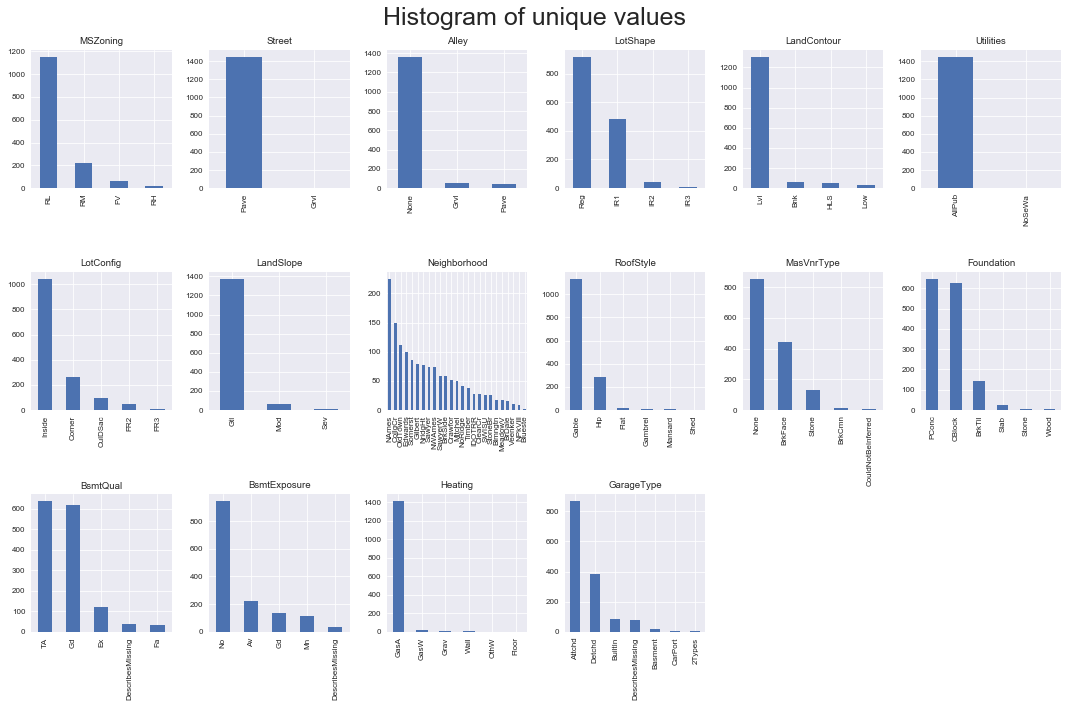

In [56]:
categoric_fx = [col for col in df_fixed.columns if all([isinstance(x,str)for x in df_fixed[col]])]
DataFrameHelper(df_fixed[categoric_fx]).plot_value_occurences(mn = (3,6), fig_size = (15,10),xmarks = True)

In [57]:
M,y = getXy(df_fixed,do_drop_first=False,drop_specifically=['MSZoning_RL',
                                                            'Street_Pave',
                                                            'Alley_None',
                                                            'LotShape_Reg',
                                                            'LandContour_Lvl',
                                                            'Utilities_AllPub',
                                                            'LotConfig_Inside',
                                                            'LandSlope_Gtl',
                                                            'Neighborhood_NAmes',
                                                            'RoofStyle_Gable',  
                                                            'MasVnrType_CouldNotBeInferred',
                                                            'Foundation_PConc',                                                            
                                                            'BsmtQual_DescribesMissing',
                                                            'BsmtExposure_DescribesMissing',                                                            
                                                            'Heating_GasA',
                                                            'GarageType_DescribesMissing'])
M['SalePrice'] = y
_ = naive_lm_predict(M, M.columns, verbose=1, sp=28,cn= 4,rnd = 2)



Results:
_____________________________________________________________________________________________________________________
LotFrontage             :0.36LotArea                 :0.6YearBuilt               :0.91YearRemodAdd            :0.54
MasVnrArea              :0.64TotalBsmtSF             :0.782ndFlrSF                :0.93BsmtFullBath            :0.36
BsmtHalfBath            :0.17FullBath                :0.72HalfBath                :0.63BedroomAbvGr            :0.68
KitchenAbvGr            :0.73TotRmsAbvGrd            :0.8Fireplaces              :0.43GarageCars              :0.86
GarageArea              :0.84HouseStyle_1.5Fin       :0.96HouseStyle_1Story       :0.98HouseStyle_2.5Fin       :0.73
HouseStyle_2.5Unf       :0.8HouseStyle_2Story       :0.97HouseStyle_SFoyer       :0.79HouseStyle_SLvl         :0.95
BldgType_1Fam           :0.94BldgType_2fmCon         :0.62BldgType_Twnhs          :0.83BldgType_TwnhsE         :0.93
MSSubClass_1.5S_FIN     :0.93MSSubClass_1S_<1945     :0

At this stage we deem our feature matrix to have sufficiently low feature colinearity. Though we are still seeing a high degree of colinearity, this is something we will see resolved by the use of regularization.

We move foward into the modelling phase with our feature matrix M of 116 features - 99 of which contain only the entries 0 and 1.

As a final EDA before we move on, consider the 1-degree and 2-degree polynomial fit of our non-binary variables and SalePrice.

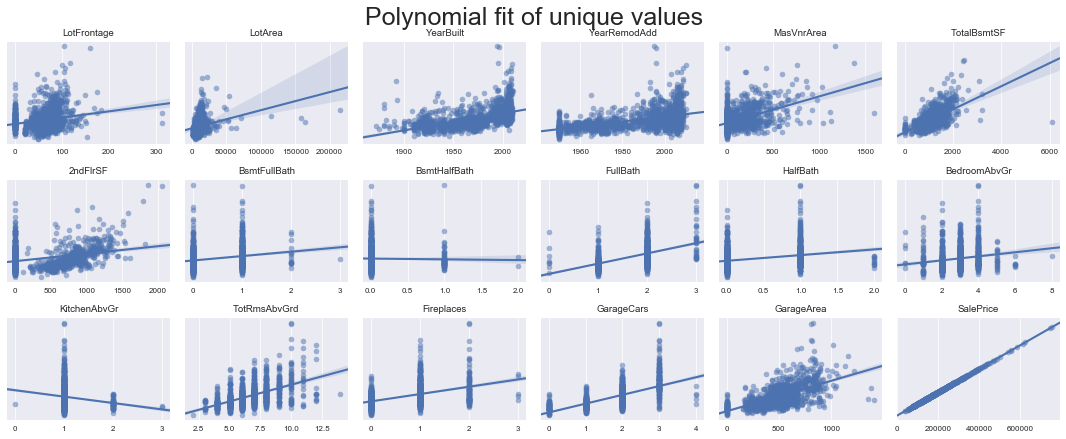

In [58]:
non_binary = M.loc[:,:'GarageArea']
non_binary['SalePrice'] = M['SalePrice']
DataFrameHelper(non_binary).plot_poly_regplot(target = 'SalePrice',mn = (4,6),fig_size = (15,8))

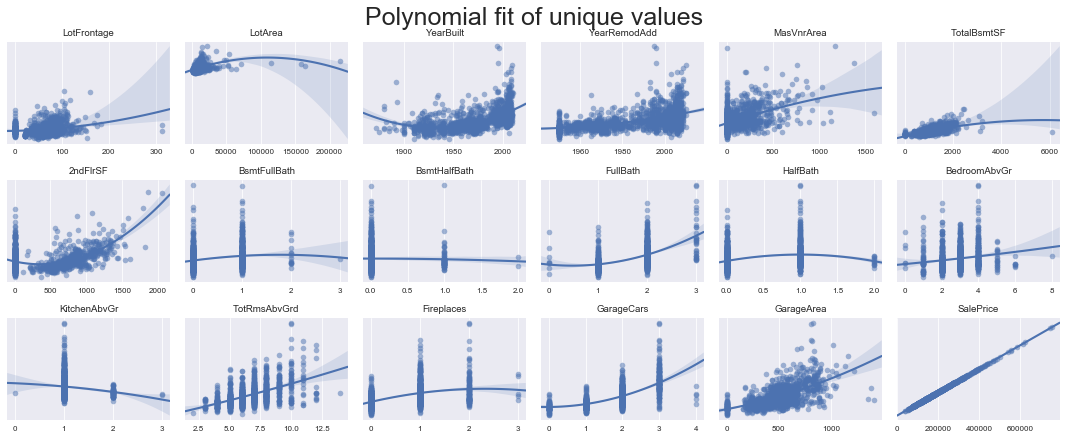

In [59]:
non_binary = M.loc[:,:'GarageArea']
non_binary['SalePrice'] = M['SalePrice']
DataFrameHelper(non_binary).plot_poly_regplot(target = 'SalePrice',mn = (4,6),fig_size = (15,8),deg = 2)

Given more time, it would be very appealing to explore a linear regression model where some features' squares are included in the feature matrix - thus resulting in a model that is linear in some features, and a second degree polynomial in a select few.

In [60]:
code_toggle()


<right><img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSgaxIA5Kd_UvhGg8_bVGdfOOpMkzFnVjslZ5SpjwN9tgqAJrDXXA" style=" margin: 15px; height: 120px"></right>

### Section 4. Modelling price as a linear function of a house's fixed features.

Our goal in this section is to find the best model for house price (in the mse metric) based on the features we have determined are fixed. In doing so we use only the information in the pre-2010 properties.

With the data cleaned and classified as it is, we have 2 choices to make in this section:

    1. What normalization to use for the data.
    2. What hyperparameters to use for Lasso, Ridge and/or ElasticNet.
    
We implement a gridsearch-like loop to explore these questions for Lasso and Ridge.

In [61]:
np.random.seed(42)
params = {'alpha':np.logspace(1,20,20, base=2), 'normalize':[False]}
dict_of_results = {}
for scaling_method in ['Mixed','StandardScaler', 'MinMaxScaler','None']:
    if scaling_method == 'None':
        sm = None
    else:
        sm = scaling_method
        
    X,y = getXy(M,do_drop_first=True,scale_technique=sm)
    
    X = X[train_set]
    y = y[train_set]
    
    for mod in ['ridge','lasso']:
        if mod == 'lasso':
            model = Lasso()
        if mod == 'ridge':
            model = Ridge()
        gs = GridSearchCV(model,params,verbose=0,cv = 5,refit=True)
        gs.fit(X,y)
        
        key = mod + ' w/ '+ scaling_method

        dict_of_results[key] = {'model':gs.best_estimator_, 'best_score':gs.best_score_, 
                            'best_params':gs.best_params_,'report': gs.cv_results_, 'bi':gs.best_index_}
    
for key in dict_of_results:
    print(key.ljust(24),'score:',str(round(dict_of_results[key]['best_score'],4)).ljust(6), 'std:',
         round(pd.DataFrame(dict_of_results[key]['report']).iloc[dict_of_results[key]['bi'],:]['std_train_score'],4)) 

ridge w/ Mixed           score: 0.8065 std: 0.0122
lasso w/ Mixed           score: 0.8103 std: 0.0121
ridge w/ StandardScaler  score: 0.8064 std: 0.0117
lasso w/ StandardScaler  score: 0.8063 std: 0.0114
ridge w/ MinMaxScaler    score: 0.8059 std: 0.0089
lasso w/ MinMaxScaler    score: 0.8093 std: 0.0119
ridge w/ None            score: 0.8057 std: 0.0121
lasso w/ None            score: 0.8087 std: 0.012


In [62]:
hyperparam_vs_score = {k:[dict_of_results[k]['report']['param_alpha'],
                          dict_of_results[k]['report']['mean_test_score']]
                          for k in list(dict_of_results.keys())} 
hyperparam_vs_score_df = pd.DataFrame(hyperparam_vs_score, index=['alphas','scores'])

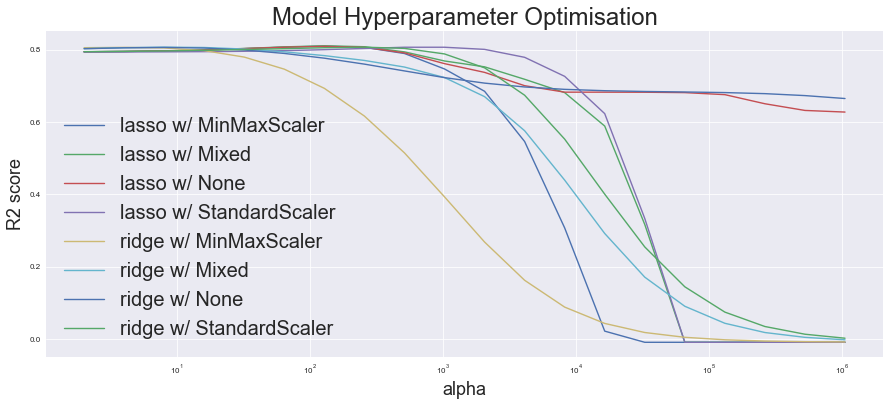

In [63]:
plt.figure(figsize=(15,6))
for mod in hyperparam_vs_score_df.columns:
    x = np.array(hyperparam_vs_score_df[mod]['alphas']),
    y = np.array(hyperparam_vs_score_df[mod]['scores'])
    plt.plot(x[0],y,label = mod)
    plt.xscale('log')
plt.ylabel('R2 score',size=18)
plt.xlabel('alpha',size =18)
plt.title('Model Hyperparameter Optimisation',size=24)
plt.legend(fontsize=20)
    
plt.show()

In all honesty, it is a photo-finish. But it gives us an idea of where to look for our best model:
    
    Lasso with an alpha between 100 and 10000.
    
Furthermore, this has helped us settle on a standarization method for our data, our very own **Mixed**. 


<right><img src="http://www.clker.com/cliparts/k/Y/O/D/0/e/balance-scale-md.png" style=" margin: 15px; height: 120px"></right>

### Introducing the Mixed scaler

In our oppinion the StandardScaler creates an absolute mess when applied to binary columns, and an enormous amount of mental acrobatics are needed to understand a single coeffient in the fineal mode. For example:

    This house has feature X; only 1 in 5 of houses have it - which places it 2sdv of 0.4 above the mean
    'Possesion-of-feature-X' value of 0.2. 
    
    Therefore the its coefficient of 65,000 in the model can be interpreted as the value that this property 
    would increase by if other houses removed feature X (or new houses without feature X are built) so as to 
    make the incidence of feature X in the house population 1 in 10, which causes having feature X to result in a 
    'Possesion-of-feature-X' value of 3std above the new mean value of 0.1.
    
    However, if the number of houses is large with 1 in 5 having feature X, removeing feature X from a house
    changes its normalized 'Possesion-of-feature-X' value from +2sdv to -0.5std, lowering it's value by
    2.5 * the model coefficient. Therefore we could rason that the inclusion of feature X is worth...
    
    162,500

Naturaly, we seek to improve upon this.

Enter the **Mixed** standarization.

It is a combination of the StandardScaler and doing nothing, for example:

Our data currently contains 17 numeric variables that represent some quantifiable aspect of a house. These columns - and (more generaly) any other with values not restricted to 0 and 1 - are normalized using the StandardScaler. Boolean columns with entries being exclusively 0 and 1 are left untouched. 

One great trait of this Mixed scaling is the interpretability of the model coefficients. Consider this ilustrative example of a fitted model:

$$\text{SalePrice} = 100,000 + 30,000\text{(LotArea)} -15000\text{(PavedDrive)}$$

If our data is scaled using the Mixed scaling we would know that:
    
   1. A house with an average LotArea that is does not have a PavedDrive is worth \$100,000.
   
   2. Having a LotArea 1sdv above the average increases your house's price by \$30,000.
        
   3. Having a PavedDrive lowers the house price by \$15,000.

In [86]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


<right><img src="http://images.clipartpanda.com/tune-clipart-62015_tuningfork_lg.gif" style=" margin: 15px; height: 120px"></right>


### Tunning the model hyperparameter

In [64]:
save_X,save_y = getXy(M,do_drop_first=True,scale_technique='Mixed')
    
Xtr = save_X[train_set]
ytr = save_y[train_set]

In [65]:
lasso = Lasso()

alphas_near_best = {'alpha':np.logspace(1,4,40,base = 10)}

gs_tuned = GridSearchCV(lasso,param_grid=alphas_near_best,cv=5)

In [66]:
fitted_model = gs_tuned.fit(Xtr,ytr)

In [67]:
plist([fitted_model.best_estimator_],title='Our roughly tuned model by cross-validated R2 score')

Our roughly tuned model by cross-validated R2 score:
_____________________________________________________________________________________________________________________
Lasso(alpha=142.51026703029993, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


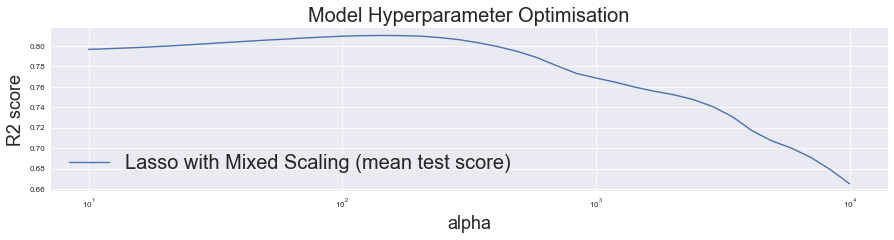

In [68]:
fm_report = pd.DataFrame(fitted_model.cv_results_)

def plot_hp_alpha_opt(rep):
    x= rep['param_alpha']
    y= rep['mean_test_score']


    plt.figure(figsize=(15,3))
    plt.plot(x,y,label = 'Lasso with Mixed Scaling (mean test score)')
    plt.xscale('log')
    plt.ylabel('R2 score',size=18)
    plt.xlabel('alpha',size =18)
    plt.title('Model Hyperparameter Optimisation',size=20)
    plt.legend(fontsize=20)

    plt.show()
    
plot_hp_alpha_opt(fm_report)

In [69]:
fitted_model.best_estimator_

Lasso(alpha=142.51026703029993, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

Seeing that the model gives the best results with alpha between 100 and 1000, throughly test this range to obtain our best model.

In [70]:
alphas_v_near_best = {'alpha':np.linspace(100,1000,901, endpoint=True)}
gs_finely_tuned = GridSearchCV(lasso,param_grid=alphas_v_near_best,cv=5)

In [71]:
best_fitted_model = gs_finely_tuned.fit(Xtr,ytr)
plist([best_fitted_model.best_estimator_],title='Our best model by cross validated R2 score')

Our best model by cross validated R2 score:
_____________________________________________________________________________________________________________________
Lasso(alpha=145.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


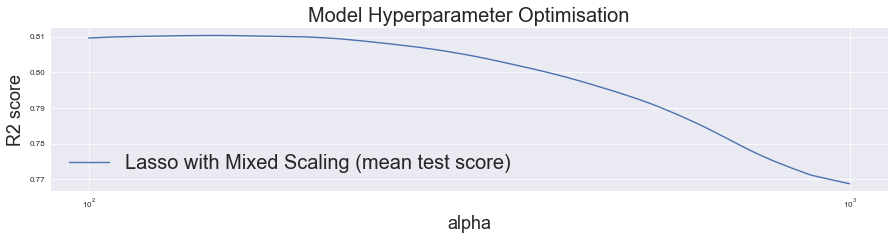

In [72]:
bfm_report = pd.DataFrame(best_fitted_model.cv_results_)
plot_hp_alpha_opt(bfm_report)

In [73]:
pd.DataFrame(best_fitted_model.cv_results_).loc[:,['mean_test_score','param_alpha',
                                                   'std_test_score']].sort_values('mean_test_score').tail(1)

,mean_test_score,param_alpha,std_test_score
45,0.810367,145,0.071055


### Model interpretation.

Let us take a closer look at the non-zero coefficients in our model.

In [74]:
model_coefficients = pd.DataFrame([save_X.columns,best_fitted_model.best_estimator_.coef_], 
                                  index = ['feat','coef'])

model_coefficients.columns = ['beta_'+str(i).rjust(3,'0') for i in range(1,120)]
model_coefficients['beta_0'] = ['Intercept',best_fitted_model.best_estimator_.intercept_]
model_coefficients = model_coefficients[sorted(model_coefficients.columns)]

In [75]:
non_zero_coefs = model_coefficients[[col for col in model_coefficients.columns if all(model_coefficients[col] != 0)]]
non_zero_coefs.columns = ['beta_'+str(i).rjust(3,'0') for i in range(0,63)]

non_zero_coefs

,beta_000,beta_001,beta_002,beta_003,beta_004,beta_005,beta_006,beta_007,beta_008,beta_009,beta_010,beta_011,beta_012,beta_013,beta_014,beta_015,beta_016,beta_017,beta_018,beta_019,beta_020,beta_021,beta_022,beta_023,beta_024,beta_025,beta_026,beta_027,beta_028,beta_029,beta_030,beta_031,beta_032,beta_033,beta_034,beta_035,beta_036,beta_037,beta_038,beta_039,beta_040,beta_041,beta_042,beta_043,beta_044,beta_045,beta_046,beta_047,beta_048,beta_049,beta_050,beta_051,beta_052,beta_053,beta_054,beta_055,beta_056,beta_057,beta_058,beta_059,beta_060,beta_061,beta_062
feat,Intercept,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,2ndFlrSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,BldgType_1Fam,BldgType_Twnhs,BldgType_TwnhsE,MSSubClass_1S_>1946,MSSubClass_2S_<1945,Feedr,RRAe,MSZoning_RM,LotShape_IR2,LotShape_IR3,LandContour_Bnk,LandContour_HLS,LotConfig_CulDSac,LotConfig_FR2,LandSlope_Sev,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Mitchel,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Veenker,RoofStyle_Hip,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,Foundation_BrkTil,Foundation_CBlock,BsmtQual_Ex,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,GarageType_Detchd
coef,-827907,-756.1,3000.61,3030.18,8019.34,2761.08,14144.6,21399.3,4646.27,1080.8,8110.1,3205.18,-4515.17,-5514.28,11093.7,6680.12,8684.95,1122.48,-2340.65,4083.24,-16020.4,7673.31,-7494.39,-3865.57,8494.85,1166.73,-9416.35,-374.486,-4260.7,10523.6,-16962,-6759.28,801.778,5465.06,-10624,-2690.94,7768.49,-2587.86,24717.5,-13007.5,-7903.31,-10435.2,-654.44,62801.3,39829.9,-901.211,-1879.03,3272.45,18806,52657.2,13956.1,5733.49,-10075.8,-1515.17,1069.55,-1551.42,-2228.07,43166.5,-504.945,16268.3,-2775.38,-12110.4,-3546.63


Thanks to the lasso regularization, our final model predicts the sale price of a based on only 62 features.

In fact, our model is fairly easy to interpret, for example:

      beta_001 tells us that the house will sell for 756 dollars less for each
      standard deviation its LotFrontage is above the average in the city of Ames.
     
      beta_002 tells us that the house will gain 3000 dollars of predicted value for each
      standard deviation its LotArea is above the average in the city of Ames.
      
      together, beta_037 = -2588 and beta_038 = 24718 (that correspond to the house being 
      in Clear Creek and Crawford respectively) tell us that the same house is worth
      27306 dollars more if built in Crawford rather than Clear Creek.
      
It would be nice to ask a resident of Ames their opinion on these results - a conversation with them would probably improve our model significantly. But as things are, we will have to asses our model in other ways.

In [84]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________



<right><img src="https://s-media-cache-ak0.pinimg.com/736x/2f/26/02/2f26023176a445895f2400dae242c58d--lighthouse-drawing-clipart-black-and-white.jpg"style=" margin: 15px; height: 120px"></right>

### Section 5: Predicting the R2 score of our model

Even though we took the liberty to standarize our feature matrix and create our dummy variables whilst considering the 2010 sales, this is something we could reasonably expect the data science team at our real estate firm to do just after a new purchasing oportunity becomes available. 

In short: 

    We never reference the sale prices of 2010 sales in 
    our process of developing our model or cleaning our data.

With very few implementation changes, our methodology could be applied to a .csv file with missing values in the 'SalePrice' column and be able to:

    1. Clean the data
    2. Produce a model to predict the unkown sale prices. 
    
But how good will this predictions be?

Looking at the 5-fold cross-validated scores of our best model, we observed them to have:

    mean: 0.81
    std:  0.07

Making some assumptions of normality for the purpose of getting a quantitative expectations for the R2 score we will observe when predicting the 2010 sale prices:

In [76]:
from scipy.stats import norm
context = 'Assuming observed r2 value is normaly distributed with mean = 0.81 and stv = 0.07:\n{}'
print(context.format('_'*_chars_per_line))
for k in [0.70,0.75,0.80,0.90]:
    print(u"\u2119"+'(observed r2 > {}) = {}'.format(str(k).ljust(4,'0'),
                                                     str(np.round(1-
                                                         norm.cdf(k,loc=0.81, scale=0.07),2)).ljust(4,'0')))

Assuming observed r2 value is normaly distributed with mean = 0.81 and stv = 0.07:
_____________________________________________________________________________________________________________________
ℙ(observed r2 > 0.70) = 0.94
ℙ(observed r2 > 0.75) = 0.80
ℙ(observed r2 > 0.80) = 0.56
ℙ(observed r2 > 0.90) = 0.10


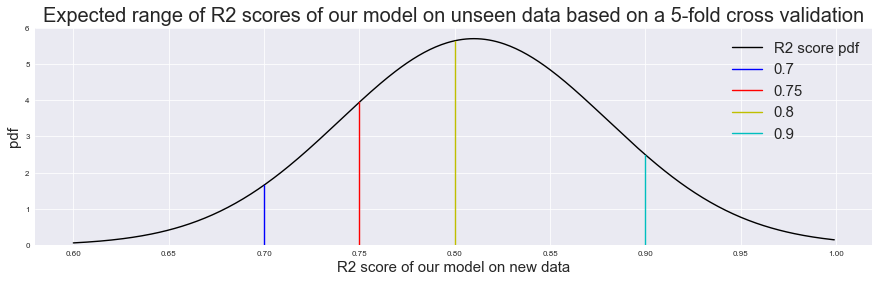

In [77]:
plt.figure(figsize=(15,4))
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0.60, 1, 0.001)
# Mean = 0.8068, SD = 0.06666.
plt.plot(x_axis, norm.pdf(x_axis,0.81,0.07),color = 'k')
plt.ylabel('pdf', size = 15)
plt.xlabel('R2 score of our model on new data', size = 15)
plt.title('Expected range of R2 scores of our model on unseen data based on a 5-fold cross validation', size=20)
plt.ylim([0,6])
for k,c in zip([0.70,0.75,0.80,0.90],['b','r','y','c']):
    plt.axvline(x=k, ymax=norm.pdf(k,loc=0.81,scale=0.07)/6, color = c)
plt.legend(['R2 score pdf']+ [0.70,0.75,0.80,0.90],fontsize = 15)
plt.show()

In [87]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________



<right><img src="http://clipartix.com/wp-content/uploads/2016/10/Recycle-symbol-clip-art-clipart-free-to-use-resource.gif" style=" margin: 15px; height: 120px"></right>

### The big reveal!
In the end, our model perfomed as expected.

In [78]:
X_test = save_X.loc[test_set.values]
y_test = save_y[test_set.values]
y_hat = best_fitted_model.predict(X_test)

print('Model predictions of 2010 sale prices:\n{}'.format('_'*_chars_per_line))

print('R2 score:                ',round(r2_score(y_test,y_hat),5))
print('Root Mean Squared Error: ',round(np.sqrt(mean_squared_error(y_test, y_hat))))

Model predictions of 2010 sale prices:
_____________________________________________________________________________________________________________________
R2 score:                 0.87399
Root Mean Squared Error:  28303.0


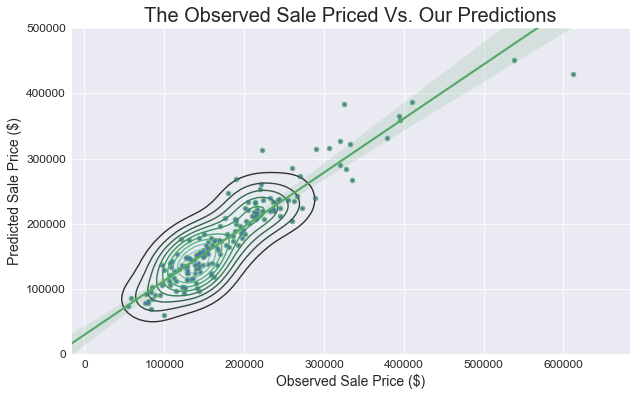

In [79]:
plt.figure(figsize=(10,6))
sns.kdeplot(y_test.ravel(),y_hat)
plt.plot(y_test,y_hat,marker = '.',linestyle = 'none')
sns.regplot(y_test,y_hat)
plt.ylabel('Predicted Sale Price ($)',size = 14)
plt.xlabel('Observed Sale Price ($)',size = 14)
plt.ylim([0,500000])
plt.title('The Observed Sale Priced Vs. Our Predictions', size=20)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

In [94]:
print('Our average error is: $', round((y_test - y_hat).mean(),2))
print('The standard deviation of our residues is: $', round((y_test - y_hat).std(),2))

Our average error is: $ 866.7
The standard deviation of our residues is: $ 28372.44


In [83]:
print('_'*_chars_per_line)
code_toggle()

_____________________________________________________________________________________________________________________


********

### Modeling the error in our model.

Consider a new target for our predictions, namely 

    residues = y_test - y_hat

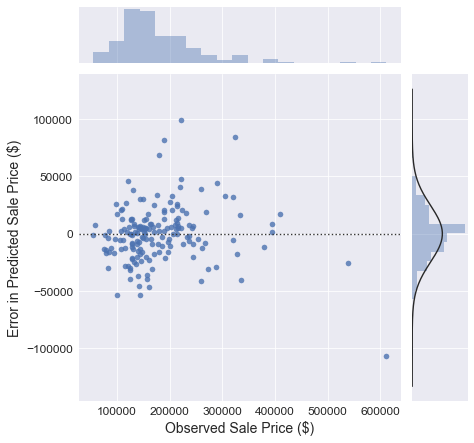

In [80]:
sns.jointplot(y_test.ravel(),y_hat, kind='resid')
plt.ylabel('Error in Predicted Sale Price ($)',size = 14)
plt.xlabel('Observed Sale Price ($)',size = 14)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.show()

In [88]:
(y_test - y_hat).mean()

866.7014746195907

In [81]:
x_axis = np.arange(residues.min(), residues.max(), 1)
# Mean = 0.8068, SD = 0.06666.
plt.plot(x_axis, norm.pdf(x_axis,residues.mean(),residues.std()),color = 'k')

plt.hist(residues,normed=True,bins=60)
plt.show()

NameError: name 'residues' is not defined

Our model managed to predict the sale prices of 2010 properties with an R2 value of 0.865, and a root mean squared error of aproximately $30k best_fitted_model.score(X_test,y_test).

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_hat))

### Section 5: Further feature engineering.

We still have several categorical features in our data. Some of which can reasonably be turned into numerical features.

In [ ]:
code_toggle()

In [ ]:
jokeX,jokey = getXy(df,do_drop_first=True,consider_columns=kfixed)

jX,jy = jokeX[test_set], jokey[test_set]
lm.fit(jX,jy).score(jX,jy)

In [ ]:
dict_of_replacement = {
       'Ex':5,  	# Excellent
       'Gd':4,  	# Good/Best in a scale of 1-4 for basement exposure
       'TA':3,  	# Typical/Average
       'Fa':2,  	# Fair
       'Po':1,  	# Poor
    
       'Av':3,  	# Second best in a scale of 1-4 for basement exposure
       'Mn':2,  	# Third best in a scale of 1-4 for basement exposure
       'No':1,  	# Worst in a scale of 1-4 for basement exposure
    
       'Y': 1,  	# Yes
       'N': 0,  	# No
       'P':.5,  	# Partial
    
       'Typ': 0,   	# Typical Functionality
       'Min1':1,   	# Minor Deductions 1
       'Min2':2,   	# Minor Deductions 2
       'Mod': 3,   	# Moderate Deductions
       'Maj1':4,   	# Major Deductions 1
       'Maj2':5,   	# Major Deductions 2
       'Sev': 6,   	# Severely Damaged
       'Sal': 7,   	# Salvage only
    
       'GdPrv':4, 	# Good Privacy
       'MnPrv':3,  	# Minimum Privacy
       'GdWo':2,  	# Good Wood
       'MnWw':1,  	# Minimum Wood/Wire # No fence will be given a value of 0
    
       'GLQ':6,   	# Good Living Quarters
       'ALQ':5,   	# Average Living Quarters
       'BLQ':4,   	# Below Average Living Quarters	
       'Rec':3,   	# Average Rec Room
       'LwQ':2,   	# Low Quality
       'Unf':1,   	# Unfinshed
       'Fin':3,  	# Finished
       'RFn':2  	# Rough Finished
    }

df_fe3 = df_fe2.applymap(lambda x: immutable_replace(x,dict_of_replacement))
df_fe3['Fence'] = df_fe3['Fence'].apply(lambda x: immutable_replace(x,{'None':0}))

categoric_fe3 = [col for col in df_fe3 if any([isinstance(entry, str) for entry in df_fe3[col]])]
numeric_fe3 = [col for col in df_fe3 if col not in categoric_fe3]

In [ ]:
print (len(categoric_fe2) - len(categoric_fe3))
print (pd.get_dummies(df_fe2).shape[1] - pd.get_dummies(df_fe3).shape[1])

Note that this immediately reduced the number of categorical columns by 8, and the ammount of dummy columns by 27.

In [ ]:
df_fixed[test_set].shape
df_m = df_fixed[[not i for i in test_set]]

In [ ]:
# here X and y correspond to our pre 2010 data.
# We will asses models and tune their hyperparameters soley on this information.
X,y = getXy(df_m, scale_technique='StandardScaler')

ridge_cv = RidgeCV(alphas=np.logspace(-4,4,9), cv = 3)
lasso_cv = LassoCV(alphas=np.logspace(1,9,9,base=2), cv = 3,max_iter=10000)
lm = LinearRegression()

ridge_score = r2_score(y,cross_val_predict(ridge_cv,X,y,cv=5))
lasso_score = r2_score(y,cross_val_predict(lasso_cv,X,y,cv=5))
lm_score = r2_score(y,cross_val_predict(lm,X,y))

print(ridge_score, lasso_score, lm_score)

In [ ]:
params = {'alpha':np.logspace(1,20,20, base=2), 'normalize':[False,True]}
dict_of_results = {}
for scaling_method in ['Mixed','StandardScaler', 'MinMaxScaler','None']:
    if scaling_method == 'None':
        sm = None
    else:
        sm = scaling_method
        
    X,y = getXy(df_m,do_drop_first=True,scale_technique=sm)
    
    for mod in ['ridge','lasso']:
        if mod == 'lasso':
            model = Lasso()
        if mod == 'ridge':
            model = Ridge()
        gs = GridSearchCV(model,params,verbose=0,cv = 5,refit=True)
        gs.fit(X,y)
        
        key = mod + ' w/ '+ scaling_method

        dict_of_results[key] = {'model':gs.best_estimator_, 'best_score':gs.best_score_, 
                            'best_params':gs.best_params_,'report': gs.cv_results_, 'bi':gs.best_index_}
    
for key in dict_of_results:
    print(key.ljust(24),'score:',str(round(dict_of_results[key]['best_score'],4)).ljust(6), 'std:',
         round(pd.DataFrame(dict_of_results[key]['report']).iloc[dict_of_results[key]['bi'],:]['std_train_score'],4))    

In [ ]:
X,y = getXy(df_m, do_drop_first=True, scale_technique='MinMaxScaler') 
dict_of_restults['lasso w/ MinMaxScaler']['model'].score(X[test_set],y[test_set])

In [ ]:
dict_of_restults['lasso w/ MinMaxScaler']['best_params']

In [ ]:
b = Lasso(alpha=128, normalize=False)
X,y = getXy(df_fixed, do_drop_first=True)
b.fit(X[[not i for i in test_set]], y[[not i for i in test_set]])

In [ ]:
b.score(X[test_set],y[test_set])

In [ ]:
X.shape

In [ ]:
for dataframe in [df,df_wd1,df_wd2,df_fe1,df_fe2,df_fe3,df_fixed]:
    b = Lasso(alpha=128, normalize=False)
    X,y = getXy(dataframe, do_drop_first=True)
    b.fit(X[[not i for i in test_set]], y[[not i for i in test_set]])
    print(b.score(X[test_set],y[test_set]))

In [ ]:
X,y = getXy(df_fe1, do_drop_first=True)
X

In [ ]:
params = {'alpha':np.logspace(1,20,20, base=2), 'normalize':[False,True]}
dict_of_results = {}
for scaling_method in ['Mixed','StandardScaler', 'MinMaxScaler','None']:
    if scaling_method == 'None':
        sm = None
    else:
        sm = scaling_method
        
    X,y = getXy(df_m,do_drop_first=True,scale_technique=sm, ignore_colums=['Utilities, Street'])
    
    for mod in ['ridge','lasso']:
        if mod == 'lasso':
            model = Lasso()
        if mod == 'ridge':
            model = Ridge()
        gs = GridSearchCV(model,params,verbose=0,cv = 5)
        gs.fit(X,y)
        
        key = mod + ' w/ '+ scaling_method

    dict_of_results[key] = {'best_score':gs.best_score_, 'best_params':gs.best_params_,'report': gs.cv_results_, 'bi':gs.best_index_}
    
for key in dict_of_results:
    print(key.ljust(24),'score:',str(round(dict_of_results[key]['best_score'],4)).ljust(6), 'std:',
         round(pd.DataFrame(dict_of_results[key]['report']).iloc[dict_of_results[key]['bi'],:]['std_train_score'],4))    

In [ ]:
params = {'alpha':np.logspace(1,20,20, base=2), 'normalize':[False,True]}
dict_of_results = {}
for scaling_method in ['Mixed','StandardScaler', 'MinMaxScaler','None']:
    if scaling_method == 'None':
        sm = None
    else:
        sm = scaling_method
        
    X,y = getXy(df_fe3,do_drop_first=True,scale_technique=sm)
    
    for mod in ['ridge','lasso']:
        if mod == 'lasso':
            model = Lasso()
        if mod == 'ridge':
            model = Ridge()
        gs = GridSearchCV(model,params,verbose=0,cv = 5)
        gs.fit(X,y)
        
        key = mod + ' w/ '+ scaling_method
        dict_of_results[key] = {'best_score':gs.best_score_, 'best_params':gs.best_params_,'report': gs.cv_results_, 'bi':gs.best_index_}

In [ ]:
for key in dict_of_results:
    print(key.ljust(24),'score:',str(round(dict_of_results[key]['best_score'],4)).ljust(6), 'std:',
         round(pd.DataFrame(dict_of_results[key]['report']).iloc[dict_of_results[key]['bi'],:]['std_train_score'],4))

In [ ]:
params = {'alpha':np.logspace(1,20,20, base=2), 'normalize':[False,True]}
dict_of_results = {}
for scaling_method in ['Mixed','StandardScaler', 'MinMaxScaler','None']:
    if scaling_method == 'None':
        sm = None
    else:
        sm = scaling_method
        
    X,y = getXy(df_fe2,do_drop_first=True,scale_technique=sm)
    
    for mod in ['ridge','lasso']:
        if mod == 'lasso':
            model = Lasso()
        if mod == 'ridge':
            model = Ridge()
        gs = GridSearchCV(model,params,verbose=0,cv = 5)
        gs.fit(X,y)
        
        key = mod + ' w/ '+ scaling_method
        dict_of_results[key] = {'best_score':gs.best_score_, 'best_params':gs.best_params_,'report': gs.cv_results_, 'bi':gs.best_index_}

In [ ]:
for key in dict_of_results:
    print(key.ljust(24),'score:',str(round(dict_of_results[key]['best_score'],4)).ljust(6), 'std:',
         round(pd.DataFrame(dict_of_results[key]['report']).iloc[dict_of_results[key]['bi'],:]['std_train_score'],4))

In [ ]:
lm = LinearRegression()

X,y = getXy(df)
print(lm.fit(X,y).score(X,y))



X,y = getXy(df_fe2)
print(lm.fit(X,y).score(X,y))

X,y = getXy(df_fe3)
print(lm.fit(X,y).score(X,y))


In [ ]:

print(lm.fit(X,y).score(X,y))
gs.score(X[test_set],y[test_set])

In [ ]:
def naive_logreg_predict(df,attributes,ignore = None ,verbose = 0, test_set = 1, myC = 10**10):
    coef_storage = {}
    results = []
    if verbose > 1: print('Predicting:\n{}'.format('_'*_chars_per_line))
    
    for col in attributes:
        X,y = getXy(df,target=col,ignore_colums=ignore)
        if verbose > 2: 
            print((str(col).ljust(14)+ ' on {} features.'.format(X.shape[1])))
        elif verbose > 1:
            print(str(col), end='|')

        # create masks for a train test split when a test boolean list is passed, 
        # or initialize the trivial mask.
        if  type(test_set) == int: 
            test = [True]*y.count()
            train = [True]*y.count()
        else:
            test = test_set
            train = [not i for i in test_set]
            
        logreg = LogisticRegression(C = myC)
        logreg.fit(X[train],y[train])
        score = logreg.score(X[test],y[test]) 
        #coef_storage[col] = pd.DataFrame({'atr':X.columns, 'coef':lm.coef_})
        
        results.append(col.ljust(14)+':'+str(round(score,4)))
        
        if verbose == -1: 
            print('Predicted {} on {} features, scored {}'.format(col,X.shape[1], round(score,4)))

    if verbose > 0: plist(results,col_num=4,spacing=24,title='\n\nResults')
    return (results, coef_storage)

In [ ]:
_ = naive_logreg_predict(df_wd2, categoric_wd2, verbose=1)

    Results:
    _____________________________________________________________________________________________
    MSSubClass    :0.8152   MSZoning      :0.8683   Street        :1.0      Alley         :0.9379   
    LotShape      :0.7138   LandContour   :0.9062   Utilities     :1.0      LotConfig     :0.7241   
    LandSlope     :0.9524   Neighborhood  :0.4945   Condition1    :0.8614   Condition2    :0.9931   
    BldgType      :0.9069   HouseStyle    :0.871    RoofStyle     :0.8069   RoofMatl      :0.9862   
    Exterior1st   :0.5117   Exterior2nd   :0.4814   MasVnrType    :0.88     ExterQual     :0.8779   
    ExterCond     :0.88     Foundation    :0.8083   BsmtQual      :0.8421   BsmtCond      :0.9248   
    BsmtExposure  :0.7034   BsmtFinType1  :0.6772   BsmtFinType2  :0.9372   Heating       :0.9848   
    HeatingQC     :0.6303   CentralAir    :0.9531   Electrical    :0.9159   KitchenQual   :0.7786   
    Functional    :0.9317   FireplaceQu   :0.6034   GarageType    :0.7993   GarageFinish  :0.6648   
    GarageQual    :0.9579   GarageCond    :0.9641   PavedDrive    :0.9283   PoolQC        :1.0      
    Fence         :0.8097   MiscFeature   :0.9972   SaleType      :0.8945   SaleCondition :0.8455   

In [ ]:
ress = {}
for col in X.columns:
     ress[col] = naive_lm_predict(['SalePrice'], ignore = [col])[1]

ress

In [ ]:
X,y = implement_modeling(df, target='TotalBsmtSF',ignore_colums=decide_to_ignore)

lm.fit(X,y)

pd.DataFrame({'atr':X.columns,'coef':lm.coef_})

In [ ]:
categorical = [col for col in df.columns if col not in df.describe().columns and col not in incidental]
df.plot_value_occurences(columns=categorical, mn = (7,6))

In [ ]:
paramgrid = {'alpha':np.logspace(-4,4,3)}

ridge = Ridge()
gs = GridSearchCV(ridge, 
                  param_grid=paramgrid,
                  cv = 2, 
                  n_jobs=3, 
                  verbose=4)

A,B = implement_modeling(df, ignore_colums=decide_to_ignore)

gs.fit(A,B)



In [ ]:
ridge.fit(A,B)

Further inspection reveals that all but one of the properties has access to all public 

In [ ]:
kfixed = ['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities',
          'LandSlope','LotConfig','Neighborhood','Condition1','Condition2','YearBuilt','YearRemodAdd','RoofStyle',
          'MasVnrType','MasVnrArea','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1','BsmtFinSF2','Heating',
          '2ndFlrSF','KitchenAbvGr','Fireplaces','GarageType','GarageCars','GarageArea']

kalterable = ['RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond','BsmtCond','BsmtFinType1',
              'BsmtFinType2','BsmtUnfSF','HeatingQC','CentralAir','Electrical','1stFlrSF','GrLivArea',
              'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','Bedroom','KitchenQual','TotRmsAbvGrd',
              'Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','WoodDeckSF',
              'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence',
              'MiscFeature','MiscVal']

    
kderivative = ['BldgType','HouseStyle','OverallQual','OverallCond','LowQualFinSF','TotalBsmtSF']

kincidental = ['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

len(kalterable + kfixed +kderivative +kincidental)

In [ ]:

kincidental == incidental

[f for f in kfixed if f not in fixed]

In [ ]:
fixed = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
         'LandContour',  'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
         'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
         'Foundation', 'BsmtExposure', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
         'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
         'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageCars', 'GarageArea']

incidental = ['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

alterable = [col for col in df.columns if col not in fixed and col not in incidental]

print('\nFixed:\n{}'.format('_'*_chars_per_line))
plist(fixed)
print('\nAlterable:\n{}'.format('_'*_chars_per_line))
plist(alterable)
print('\nIncidental:\n{}'.format('_'*_chars_per_line))
plist(incidental)

In [ ]:
df.plot_value_occurences(columns=df.columns.tolist()[0:17])

In [ ]:
df_data_cleaning.set_checkpoint()

In [ ]:
for col in [col for col in df.columns if types_df[col]["<class 'str'>"] > 0]:
    print(col+':')
    plist(df[col].unique(), spacing=10,rstart = '> ')
    print()

In [ ]:

    
class DataExplorer(DataFrameHelper):

    def explore_correlation(self,):
        sns.regplot(self[cols],y,order=2)

        

In [ ]:
df1 = DataExplorer(df)

In [ ]:
test = (df['YrSold'] == 2010).values
train = (df['YrSold'] != 2010).values

In [ ]:
dat = pd.DataFrame()
for st in [None,'S','M']:
    for it in [True,False]:
        dat = pd.concat([dat,implement_modeling(df,model='lasso',
                                               consider_columns = fixed,
                                               get_dummies=True,
                                               scale_technique=st,
                                               internal_norm = it).to_df()])


dat

In [ ]:
implement_modeling(df,model='ridge',scale_technique='M',
                   consider_columns = fixed,
                   get_dummies=True).to_df()

In [ ]:
implement_modeling(df,model='ridge',scale_technique=None,
                   consider_columns = fixed,
                   get_dummies=True).to_df()

In [ ]:
implement_modeling(df,model='ridge',scale_technique=None,
                   consider_columns = fixed,
                   get_dummies=True,
                   internal_norm = True).to_df()

In [ ]:
parameter_space = {model:['lm','ridge','lasso'],
                    {alpha : [0.1,1,10,100],
        for consider_col in [fixed]:
            for scale_technique in [None,'S','M']:
                for ddf in [True,False]:

def hyper_parameter_explorer(di)
    for 

In [ ]:
dat = pd.DataFrame()
for mod in ['ridge']:
    for alpha in [0.1,1,10,100]:
        for consider_col in [fixed]:
            for scale_technique in [None,'S','M']:
                for ddf in [True,False]:
                    
                    key = (mod.rjust(7)
                       +' alpha='+str(round(alpha,3)).rjust(4)
                       +' Scaled by '+str(scale_technique).rjust(5)
                       +' Dropping frist: '+str(ddf).rjust(5))
                    print (key)
                    
                    report = implement_modeling(df1,model=mod,consider_columns=consider_col,
                                                scale_technique = scale_technique,model_alpha=alpha,
                                                do_drop_first = ddf)
                    
                    dat = pd.concat([dat, report.to_df()],axis=0)

In [ ]:
dat.reset_index().sort_values('cv_score')

In [ ]:
sort = sorted([(di[key].true_score.round(4),key) for key in di.keys()])
for (x,y) in sort: print(y,x)

In [ ]:
for i in range(100):
    k=np.sqrt(i)
    print (i,np.floor(k+1) * np.floor(k))

(0.85340352664490027, 'ridge10None')

0.85426008217280969 ridge10None after!!!

(0.87057883511318945, 'ridge10None')]


    (0.87057883511318945, 'ridge10NoneTrue'),
    (0.87113126001225183, 'ridge10NoneFalse')]


    (0.87057883511318945, 'ridge10NoneTrue'),
     (0.87113126001225183, 'ridge10NoneFalse') worked better than alpha = 100


before altering the qual to num:

        (0.8671087710751757, 'ridge alpha=100 Scaled by S Dropping frist: False'),
     (0.87057883511318945, 'ridge alpha=10 Scaled by None Dropping frist: True'),
     (0.87113126001225183, 'ridge alpha=10 Scaled by None Dropping frist: False')]
     
after 

     (0.8671087710751757, 'ridge alpha=100 Scaled by S Dropping frist: False'),
     (0.87057883511318945, 'ridge alpha=10 Scaled by None Dropping frist: True'),
     (0.87113126001225183, 'ridge alpha=10 Scaled by None Dropping frist: False')]


In [ ]:
datatat = pd.read_csv('../project-02/housing.csv')


In [ ]:
pd.DataFrame(datatat.dtypes.value_counts(dropna=False))

In [ ]:
pd.DataFrame(datatat.isnull().sum())

In [ ]:
pd.DataFrame(datatat.applymap(type)).unique().T

In [ ]:
{k:{key:datatat[key].apply(type).value_counts(dropnan=False) for key in datatat.columns} for }

In [ ]:
pd.DataFrame({key:datatat[key].apply(extended_type).value_counts(dropna = False) for key in datatat.columns})

https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer

In [ ]:
incidental<sup>[1](#myfootnote1)</sup>.
<a name="myfootnote1">1</a>: This is a footnote